[FILES]
  GMRP_FIXED_FILE : C:\Users\bseis\ABthesis\data\analysis\b_gmrp_unconstrained_qp_asof20180629_top1000_ridge1e-05.parquet | exists: True
  ONLINE_WIDE_FILE: C:\Users\bseis\ABthesis\data\analysis\online_gmrp\gmrp_weights_online_expanding_wide_2007_to_2017.parquet | exists: True
  MI_FILE         : C:\Users\bseis\ABthesis\data\analysis\mi_bits_tier1_asof20180629_k6_min156_sqrt.parquet | exists: True
  NMI_FILE (fb)   : C:\Users\bseis\ABthesis\data\analysis\nmi_tier1_asof20180629_k6_min156.parquet | exists: False
[core] using full core file: crsp_weekly_core.parquet
Validation shapes: tickers (339, 1634) | permnos (339, 1569)
[MI (TRAIN, bits)] non-finite → 0 (count=94648)
[Q] using MI bits kernel from mi_bits_tier1_asof20180629_k6_min156_sqrt.parquet
[axis=permno] kernel labels intersecting validation returns: 927
[static validation universe] N_assets = 927
[Q_reg_full] ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.384e+02 | cond≈1.38e+07
Rebalance dates: 2018-07-27T00:00:00.0000

,GMRP_fixed,GMRP_online,GMV,MVP,CapW,EW
date,,,,,,
2024-10-25,-0.025547,-0.018842,-0.015771,-0.011524,-0.009076,-0.022579
2024-11-01,0.001483,-0.011461,-0.007558,-0.001676,-0.012844,-0.001841
2024-11-08,0.068821,0.090168,0.056426,0.056153,0.047962,0.049895
2024-11-15,-0.016465,-0.022646,-0.008207,-0.016711,-0.019982,-0.019608
2024-11-22,0.046780,0.037797,0.030862,0.032388,0.020464,0.030108
2024-11-29,0.005359,-0.002819,0.013264,0.009798,0.011678,0.011644
2024-12-06,0.019323,0.012111,-0.010195,-0.015297,0.009678,-0.011061
2024-12-13,-0.018757,-0.013363,-0.004462,-0.015606,-0.014098,-0.016489
2024-12-20,-0.033943,-0.020624,-0.058238,-0.032296,-0.022158,-0.035837


,n_weeks,ann_ret,ann_vol,sharpe,info_ratio,mdd,sortino,calmar,dd_dev
strategy,,,,,,,,,
CapW,335,0.141289,0.191487,0.787562,NaN,-0.322326,1.134212,0.438340,0.132963
EW,335,0.100930,0.223438,0.543224,-0.370706,-0.411845,0.782459,0.245067,0.155123
GMRP_online,335,0.102664,0.233501,0.537199,-0.253754,-0.411402,0.762042,0.249547,0.164606
GMRP_fixed,335,0.106581,0.271745,0.509230,-0.098713,-0.473611,0.749808,0.225039,0.184555
GMV,335,0.041044,0.193833,0.305714,-0.761390,-0.330334,0.413142,0.124251,0.143431
MVP,335,0.008868,0.221891,0.155785,-0.630889,-0.345335,0.197373,0.025679,0.175137


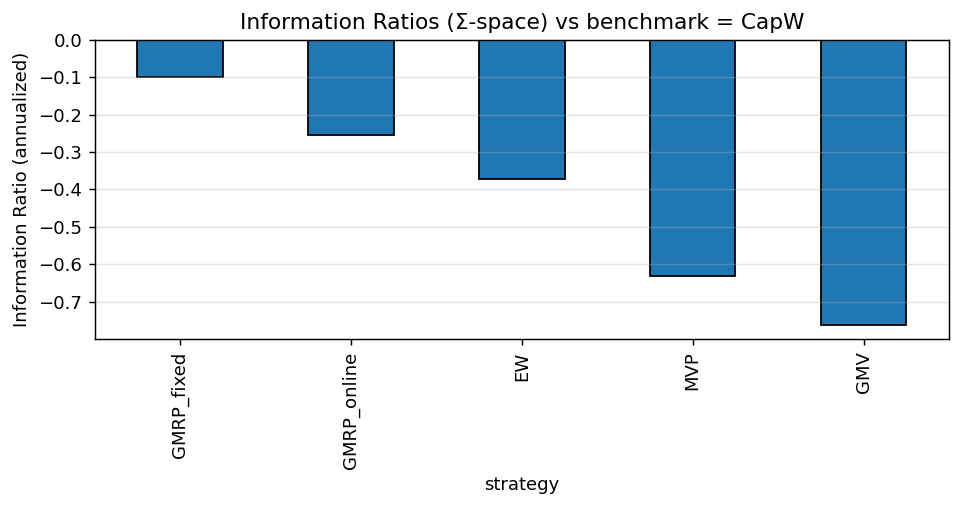

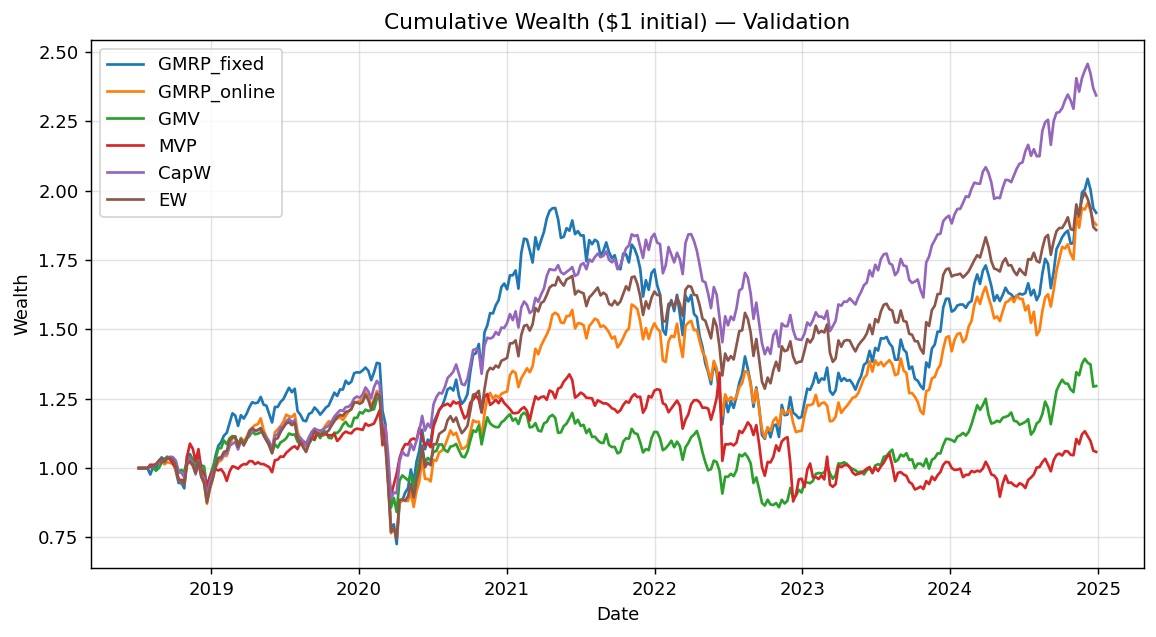

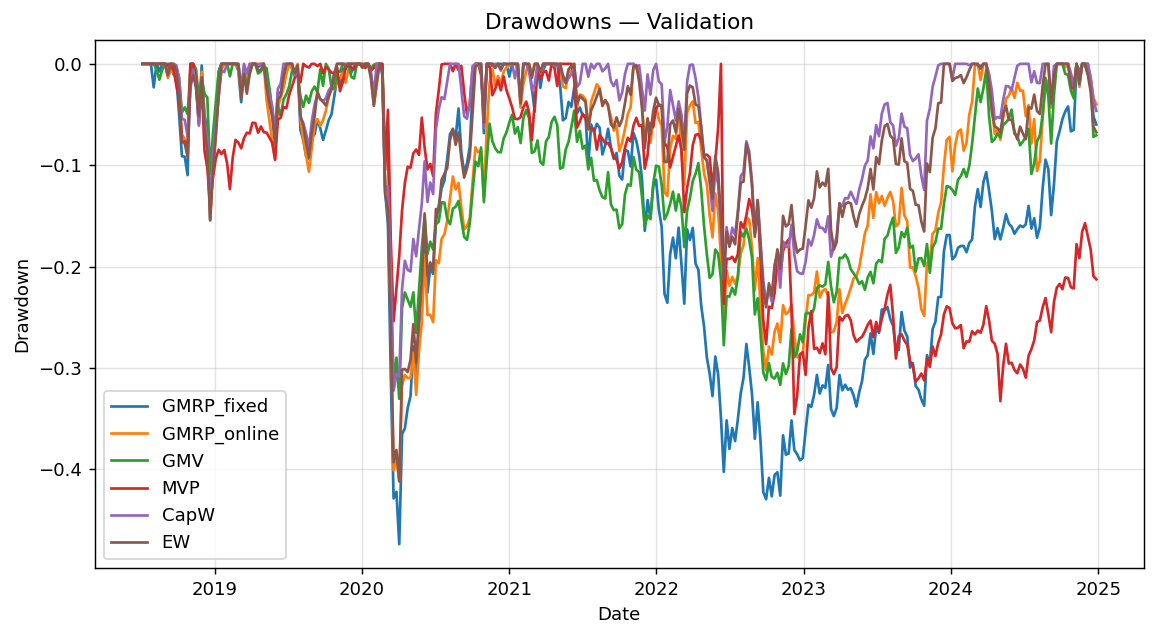

,mi_sharpe,mi_info_ratio,sigmaQ_avg
strategy,,,
GMRP_fixed,1.410722,-0.004257,0.013603
GMV,0.078860,-0.025626,0.104204
GMRP_online,0.078159,-0.005732,0.222558
CapW,0.053456,NaN,0.391223
EW,0.047564,-0.005478,0.353880
MVP,0.009280,-0.017758,0.516534


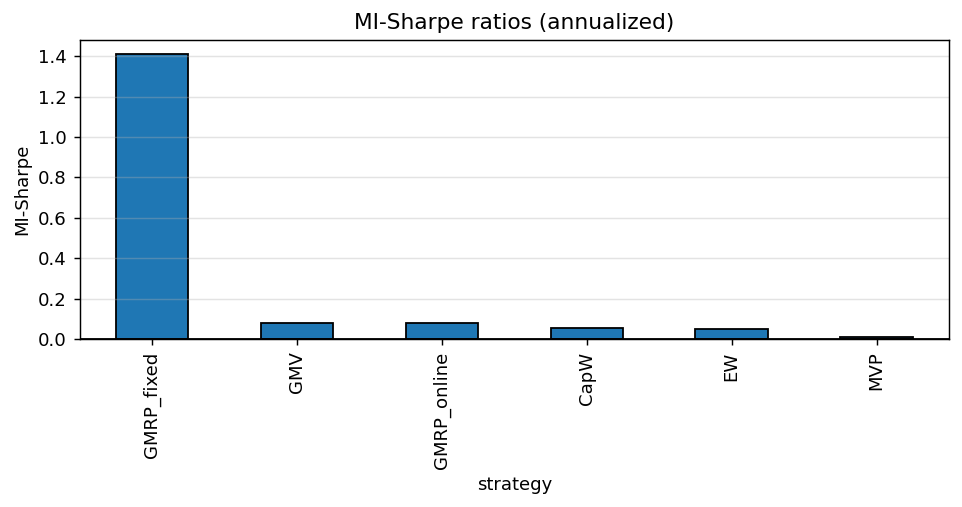

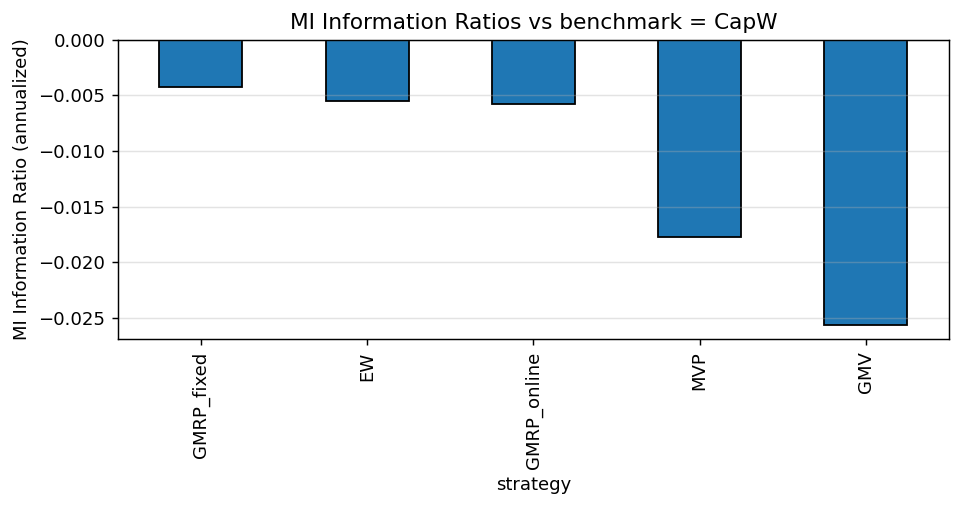

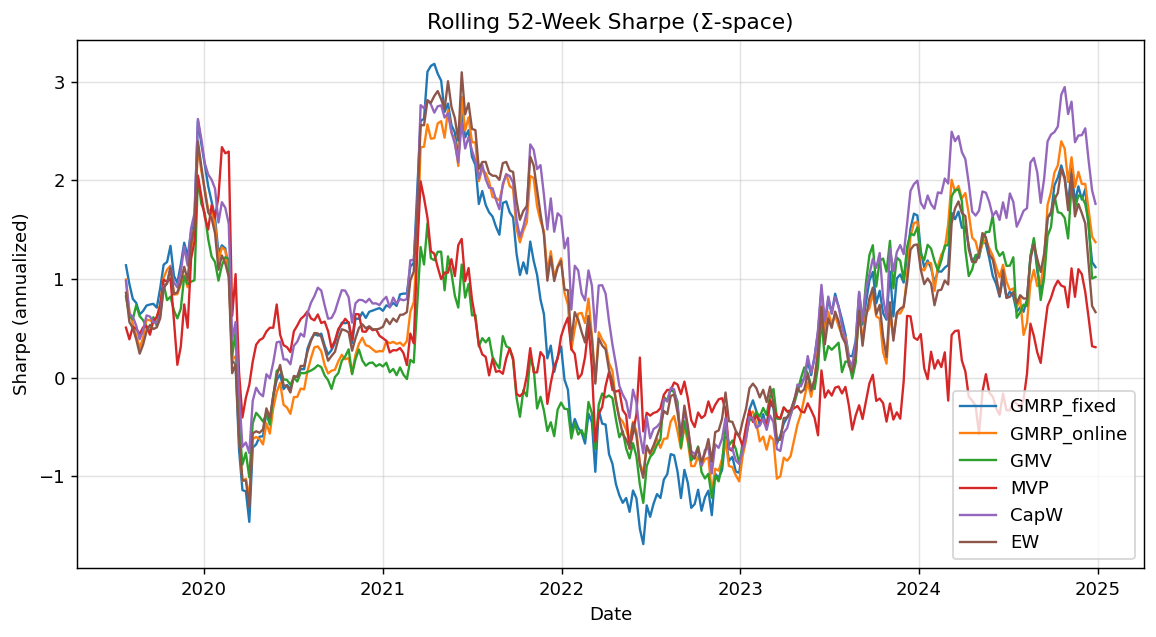

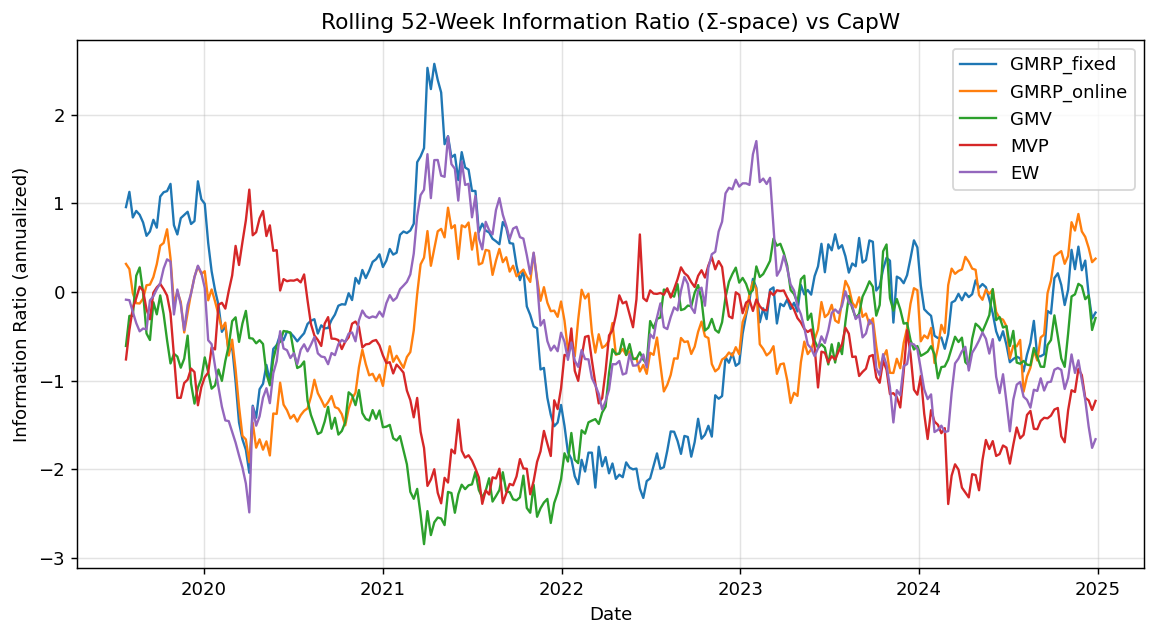

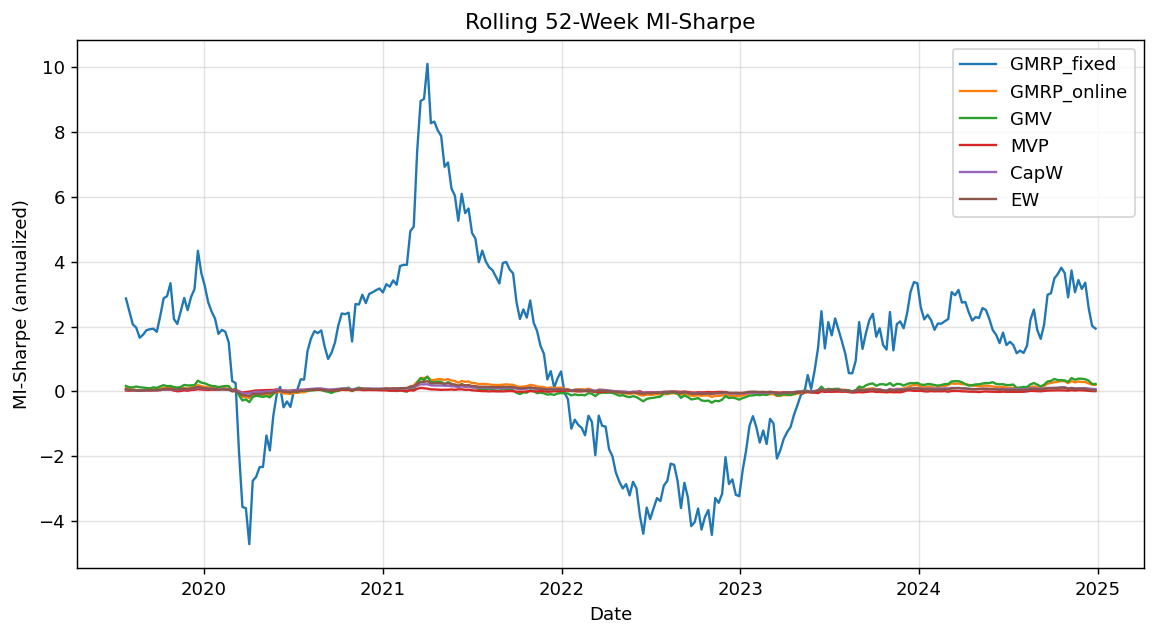

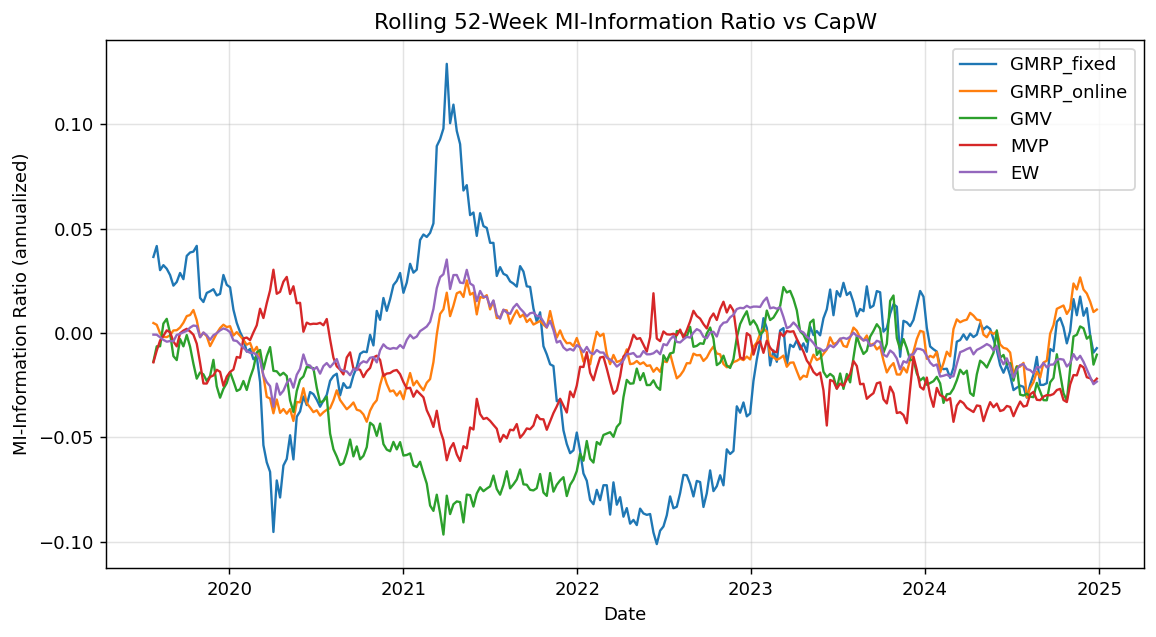

In [1]:
# Setup, imports, paths, parameters
import os, re, glob, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

from numpy.linalg import solve, lstsq, eigvalsh, eigh
from sklearn.covariance import LedoitWolf
from scipy.stats import norm

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 130
pd.set_option("display.width", 180)
pd.options.display.float_format = "{:,.6f}".format
np.random.seed(123)

# Data locations.
DATA      = Path(r"C:\Users\bseis\ABthesis\data")
PROCESSED = DATA / "processed"
ANALYSIS  = DATA / "analysis"

# Output folder for this experiment run.
OUTDIR = ANALYSIS / "exp3_out_of_sample_performance_v2"
OUTDIR.mkdir(parents=True, exist_ok=True)

# Train/validation windows.
TRAIN_START = pd.Timestamp("1997-01-01")
ASOF_TRAIN  = pd.Timestamp("2018-06-29")

VAL_START   = pd.Timestamp("2018-06-30")
VAL_END     = pd.Timestamp("2024-12-30")

# Universe membership and core return panels for train and validation.
UNIV_TRAIN_FILE = PROCESSED / "crsp_weekly_universe_1997-01-01_to_2018-06-29_top1000_liq20p_rebalance-monthly_W-FRI.parquet"
UNIV_VALID_FILE = PROCESSED / "crsp_weekly_universe_2018-06-30_to_2024-12-30_top1000_liq20p_rebalance-monthly_W-FRI.parquet"

CORE_FULL_FILE  = PROCESSED / "crsp_weekly_core.parquet"
CORE_TRAIN_FILE = PROCESSED / "crsp_weekly_core_1997-01-01_to_2018-06-29.parquet"
CORE_VAL_FILE   = PROCESSED / "crsp_weekly_core_2018-06-30_to_2024-12-30.parquet"

# Fixed GMRP weights from the training run and the online schedule produced elsewhere.
GMRP_FIXED_FILE = ANALYSIS / "b_gmrp_unconstrained_qp_asof20180629_top1000_ridge1e-05.parquet"

ONLINE_DIR       = ANALYSIS / "online_gmrp"
ONLINE_WIDE_FILE = next(iter(ONLINE_DIR.glob("gmrp_weights_online_expanding_wide_*.parquet")), None)

# Dependence kernel trained on the training window (MI preferred, NMI as fallback).
MI_FILE  = ANALYSIS / "mi_bits_tier1_asof20180629_k6_min156_sqrt.parquet"
NMI_FILE = ANALYSIS / "nmi_tier1_asof20180629_k6_min156.parquet"

# Backtest settings.
REBALANCE      = "monthly"
ROLL_WIN_WEEKS = 156
SHRINK_ALPHA   = 0.10
SIGMA_RIDGE    = 1e-6

# Coverage requirement for GMV training panel construction.
GMV_COVERAGE_FLOOR = 52

# Kernel conditioning parameters (mirrors the in-sample Q stabilization).
Q_RIDGE_MIN_EIG = 1e-6
Q_KAPPA_MAX     = 1e8

# Extra stabilization for the online long/short weights.
GMRP_ONLINE_MAX_ABS = 0.02
GMRP_ONLINE_L1_MAX  = 3.0

WEEK_PER_YEAR = 52

print("[FILES]")
print("  GMRP_FIXED_FILE :", GMRP_FIXED_FILE, "| exists:", GMRP_FIXED_FILE.exists())
print("  ONLINE_WIDE_FILE:", ONLINE_WIDE_FILE, "| exists:", ONLINE_WIDE_FILE is not None)
print("  MI_FILE         :", MI_FILE,         "| exists:", MI_FILE.exists())
print("  NMI_FILE (fb)   :", NMI_FILE,        "| exists:", NMI_FILE.exists())

# Utility functions (labels, kernel, metrics)

def parse_label_to_ticker_and_permno(label: str):
    # Best-effort parsing of an asset label into a ticker token and/or PERMNO.
    s = str(label).strip()
    tkr, pno = None, None

    if "—" in s:
        t = s.split("—")[0].strip().upper()
        if t and t.isalpha():
            tkr = t
    elif " - " in s:
        t = s.split(" - ")[0].strip().upper()
        if t and t.isalpha():
            tkr = t

    if tkr is None:
        parts = re.split(r"[ _\-\|]+", s)
        if parts and parts[0].isalpha():
            tkr = parts[0].upper()

    m = re.search(r"(\d{4,7})$", s)
    if m:
        try:
            pno = int(m.group(1))
        except ValueError:
            pno = None

    m2 = re.search(r"PERMNO[_\-\s]*(\d{4,7})", s, flags=re.IGNORECASE)
    if (pno is None) and m2:
        try:
            pno = int(m2.group(1))
        except ValueError:
            pno = None

    return tkr, pno

def normalize_online_label(lbl: str, axis: str = "ticker"):
    # Normalize online-weight column labels so they can be mapped to the validation axis cleanly.
    s = str(lbl).strip()

    m = re.match(r"PERMNO[_\-\s]*(\d{4,7})$", s, flags=re.IGNORECASE)
    if m:
        return m.group(1) if axis == "permno" else None

    m = re.match(r"([A-Z0-9\.\-]+)[_\-\s]+\d{4,7}$", s)
    if m:
        t = m.group(1).upper()
        return t if axis == "ticker" else None

    if axis == "ticker":
        if re.match(r"^[A-Z][A-Z0-9\.\-]*$", s):
            return s.upper()
        return None

    m = re.match(r"^(\d{4,7})$", s)
    if m:
        return m.group(1)
    return None

def sanitize_kernel_bits(df: pd.DataFrame, name="Q") -> pd.DataFrame:
    # MI/NMI kernels should be finite, symmetric, nonnegative, and have a zero diagonal.
    assert df.index.equals(df.columns), f"{name}: index != columns"
    A = df.to_numpy(dtype="float64", copy=True)
    bad = ~np.isfinite(A)
    if bad.any():
        print(f"[{name}] non-finite → 0 (count={int(bad.sum())})")
        A[bad] = 0.0
    A = np.maximum(A, 0.0)
    A = 0.5 * (A + A.T)
    np.fill_diagonal(A, 0.0)
    return pd.DataFrame(A, index=df.index, columns=df.columns)

def nearest_psd(A: np.ndarray, eps_eig=0.0) -> np.ndarray:
    # PSD projection via eigenvalue clipping.
    A = 0.5 * (A + A.T)
    w, V = eigh(A)
    w = np.maximum(w, eps_eig)
    B = (V * w) @ V.T
    return 0.5 * (B + B.T)

def choose_ridge(
    Qpsd: np.ndarray,
    target_min: float = Q_RIDGE_MIN_EIG,
    kappa_max: float = Q_KAPPA_MAX,
    max_steps: int = 10,
) -> float:
    # Add the smallest diagonal ridge on a log scale that meets min-eig and conditioning targets.
    w = eigvalsh(Qpsd)
    if (w[0] >= target_min) and (w[-1] / max(w[0], 1e-16) <= kappa_max):
        return 0.0

    ridge = 1e-8
    for _ in range(max_steps):
        w2 = eigvalsh(Qpsd + ridge * np.eye(Qpsd.shape[0]))
        if (w2[0] >= target_min) and (w2[-1] / w2[0] <= kappa_max):
            return ridge
        ridge *= 10

    print(f"[Q] warning: using ridge={ridge/10:.1e} (target cond not reached).")
    return ridge / 10.0

def pick_solver():
    # Pick a solver that is likely to work for the small QPs used in this notebook.
    s = set(cp.installed_solvers())
    for cand in ("CLARABEL", "OSQP", "SCS", "ECOS"):
        if cand in s:
            return cand
    return None

def to_cum_simple(ret: pd.Series) -> pd.Series:
    # Standard multiplicative wealth curve.
    return (1.0 + ret.fillna(0.0)).cumprod()

def to_cum_log(ret: pd.Series) -> pd.Series:
    # Log wealth curve (handy for additive comparisons).
    return np.log1p(ret.fillna(0.0)).cumsum()

def ann_sharpe(ret: pd.Series, rf_weekly: float = 0.0) -> float:
    # Annualized Sharpe ratio from weekly returns.
    ex = ret - rf_weekly
    mu, sd = ex.mean(), ex.std(ddof=1)
    return np.nan if sd <= 0 or not np.isfinite(sd) else (mu / sd) * np.sqrt(WEEK_PER_YEAR)

def info_ratio(ret: pd.Series, bench: pd.Series) -> float:
    # Annualized information ratio against a benchmark series.
    a, b = ret.align(bench, join="inner")
    diff = a - b
    mu, sd = diff.mean(), diff.std(ddof=1)
    return np.nan if sd <= 0 or not np.isfinite(sd) else (mu / sd) * np.sqrt(WEEK_PER_YEAR)

def max_drawdown(ret: pd.Series) -> float:
    # Max drawdown on the cumulative simple-return wealth curve.
    wealth = to_cum_simple(ret)
    peak = wealth.cummax()
    dd = (wealth - peak) / peak
    return float(dd.min())

def downside_deviation(ret: pd.Series, mar: float = 0.0) -> float:
    # Annualized downside deviation relative to a minimum acceptable return (weekly).
    ex = ret - mar
    downside = np.minimum(0.0, ex)
    var = np.mean(downside**2)
    return np.sqrt(var) * np.sqrt(WEEK_PER_YEAR)

def sortino(ret: pd.Series, mar: float = 0.0) -> float:
    # Annualized Sortino ratio using downside deviation.
    ex = ret - mar
    dd_week = downside_deviation(ret, mar=mar) / np.sqrt(WEEK_PER_YEAR)
    mu = ex.mean()
    return np.nan if dd_week <= 0 or not np.isfinite(dd_week) else (mu / dd_week) * np.sqrt(WEEK_PER_YEAR)

def calmar(ret: pd.Series) -> float:
    # Calmar ratio: CAGR divided by absolute max drawdown.
    r = ret.dropna()
    if r.empty:
        return np.nan
    ann_ret = (1.0 + r).prod() ** (WEEK_PER_YEAR / len(r)) - 1.0
    mdd = abs(max_drawdown(r))
    return np.nan if mdd <= 0 or not np.isfinite(mdd) else ann_ret / mdd

def sigma_Q(Q: np.ndarray, b: np.ndarray) -> float:
    # MI-space risk measure used throughout the thesis: sqrt(b'Qb).
    return float(np.sqrt(max(b @ (Q @ b), 0.0)))

def mi_sharpe(ret: pd.Series, sigmaQ_weekly: pd.Series) -> float:
    # Sharpe-like ratio using sigma_Q as the risk denominator.
    r = ret.dropna()
    s = sigmaQ_weekly.reindex(r.index).dropna()
    common = r.index.intersection(s.index)
    if len(common) == 0:
        return np.nan
    mu = r.loc[common].mean()
    s_avg = s.loc[common].mean()
    return np.nan if s_avg <= 0 else (mu / s_avg) * np.sqrt(WEEK_PER_YEAR)

def mi_information_ratio(
    ret: pd.Series,
    bench: pd.Series,
    sigmaQ: pd.Series,
    sigmaQ_bench: pd.Series,
) -> float:
    # IR-like ratio using sigma_Q-based tracking error proxy.
    a, b = ret.align(bench, join="inner")
    diff = a - b
    if diff.empty:
        return np.nan
    mu = diff.mean()
    s1 = sigmaQ.reindex(diff.index).mean()
    s2 = sigmaQ_bench.reindex(diff.index).mean()
    s_te = s1 + s2
    return np.nan if s_te <= 0 else (mu / s_te) * np.sqrt(WEEK_PER_YEAR)

def rolling_sharpe(ret: pd.Series, window: int = 52) -> pd.Series:
    # Rolling Sharpe computed directly from the trailing window.
    r = ret.dropna()
    return r.rolling(window).apply(
        lambda z: (z.mean() / z.std(ddof=1)) * np.sqrt(WEEK_PER_YEAR)
        if np.std(z, ddof=1) > 0 else np.nan,
        raw=False,
    )

def rolling_info_ratio(ret: pd.Series, bench: pd.Series, window: int = 52) -> pd.Series:
    # Rolling information ratio vs benchmark.
    a, b = ret.align(bench, join="inner")
    diff = a - b
    return diff.rolling(window).apply(
        lambda z: (z.mean() / z.std(ddof=1)) * np.sqrt(WEEK_PER_YEAR)
        if np.std(z, ddof=1) > 0 else np.nan,
        raw=False,
    )

def rolling_mi_sharpe(ret: pd.Series, sQ: pd.Series, window: int = 52) -> pd.Series:
    # Rolling MI-Sharpe using rolling means of return and sigma_Q.
    a = ret.rolling(window).mean()
    b = sQ.rolling(window).mean()
    out = (a / b) * np.sqrt(WEEK_PER_YEAR)
    out[(b <= 0) | (~np.isfinite(out))] = np.nan
    return out

def rolling_mi_info_ratio(
    ret: pd.Series,
    bench: pd.Series,
    sQ: pd.Series,
    sQ_bench: pd.Series,
    window: int = 52,
) -> pd.Series:
    # Rolling MI-IR vs benchmark, using sigma_Q sums as the tracking-error proxy.
    a, b = ret.align(bench, join="inner")
    diff = a - b
    num = diff.rolling(window).mean()
    s1 = sQ.reindex(diff.index)
    s2 = sQ_bench.reindex(diff.index)
    te = (s1 + s2).rolling(window).mean()
    out = (num / te) * np.sqrt(WEEK_PER_YEAR)
    out[(te <= 0) | (~np.isfinite(out))] = np.nan
    return out

def project_longshort_weights(
    w_init: pd.Series,
    max_abs: float = GMRP_ONLINE_MAX_ABS,
    l1_max: float = GMRP_ONLINE_L1_MAX,
    name: str = "online_gmrp",
) -> pd.Series:
    # Project an unconstrained long/short vector onto a stable constraint set.
    w = w_init.dropna().astype(float)
    if w.empty:
        return w

    total = w.sum()
    if not np.isfinite(total) or abs(total) < 1e-12:
        return w

    w = w / total
    idx = w.index.to_list()
    b0 = w.to_numpy(dtype=float)
    n = len(idx)

    b = cp.Variable(n)
    cons = [cp.sum(b) == 1.0]

    if max_abs is not None and max_abs > 0:
        cons.append(b <= max_abs)
        cons.append(b >= -max_abs)

    if l1_max is not None and l1_max > 0:
        cons.append(cp.norm1(b) <= float(l1_max))

    obj = cp.Minimize(cp.sum_squares(b - b0))

    prob = cp.Problem(obj, cons)
    solver = pick_solver() or "SCS"
    kw = dict(verbose=False, warm_start=True)
    if solver == "SCS":
        kw.update(dict(eps=1e-5, max_iters=300000))
    if solver == "OSQP":
        kw.update(dict(eps_abs=1e-8, eps_rel=1e-8, max_iter=300000, polish=True))

    try:
        prob.solve(solver=solver, **kw)
    except Exception as e:
        print(f"[{name}] projection QP failed with {e}; falling back to simple clip/renorm.")
        arr = np.clip(b0, -max_abs, max_abs)
        s = arr.sum()
        if abs(s) < 1e-12:
            return pd.Series(arr, index=idx, name=w_init.name)
        arr = arr / s
        return pd.Series(arr, index=idx, name=w_init.name)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        print(f"[{name}] projection status={prob.status}; using clipped/renorm fallback.")
        arr = np.clip(b0, -max_abs, max_abs)
        s = arr.sum()
        if abs(s) < 1e-12:
            return pd.Series(arr, index=idx, name=w_init.name)
        arr = arr / s
        return pd.Series(arr, index=idx, name=w_init.name)

    arr = np.asarray(b.value, dtype=float).ravel()
    arr[~np.isfinite(arr)] = 0.0
    s = arr.sum()
    if abs(s) > 1e-12:
        arr = arr / s

    return pd.Series(arr, index=idx, name=w_init.name)

# load TRAIN + VALIDATION universes & returns

u_train = pd.read_parquet(UNIV_TRAIN_FILE).copy()
u_valid = pd.read_parquet(UNIV_VALID_FILE).copy()

# Normalize key columns once so later joins are straightforward.
for df in (u_train, u_valid):
    df["date"]   = pd.to_datetime(df["date"], errors="coerce")
    df["permno"] = pd.to_numeric(df["permno"], errors="coerce").astype("Int64")
    if "ticker" in df.columns:
        df["ticker"] = df["ticker"].astype(str).str.upper()

# Load core returns, preferring the full file if it's available.
core_full = None
if CORE_FULL_FILE.exists():
    print("[core] using full core file:", CORE_FULL_FILE.name)
    core_full = pd.read_parquet(CORE_FULL_FILE).copy()
    core_full["date"]   = pd.to_datetime(core_full["date"], errors="coerce")
    core_full["permno"] = pd.to_numeric(core_full["permno"], errors="coerce").astype("Int64")
    if "ticker" in core_full.columns:
        core_full["ticker"] = core_full["ticker"].astype(str).str.upper()

# Train slice.
if core_full is not None:
    core_train = core_full[(core_full["date"] >= TRAIN_START) & (core_full["date"] <= ASOF_TRAIN)].copy()
elif CORE_TRAIN_FILE.exists():
    print("[core] using TRAIN core file:", CORE_TRAIN_FILE.name)
    core_train = pd.read_parquet(CORE_TRAIN_FILE).copy()
    core_train["date"]   = pd.to_datetime(core_train["date"], errors="coerce")
    core_train["permno"] = pd.to_numeric(core_train["permno"], errors="coerce").astype("Int64")
    if "ticker" in core_train.columns:
        core_train["ticker"] = core_train["ticker"].astype(str).str.upper()
else:
    raise FileNotFoundError("No TRAIN core file found.")

# Validation slice.
if core_full is not None:
    core_val = core_full[(core_full["date"] >= VAL_START) & (core_full["date"] <= VAL_END)].copy()
elif CORE_VAL_FILE.exists():
    print("[core] using VALIDATION core file:", CORE_VAL_FILE.name)
    core_val = pd.read_parquet(CORE_VAL_FILE).copy()
    core_val["date"]   = pd.to_datetime(core_val["date"], errors="coerce")
    core_val["permno"] = pd.to_numeric(core_val["permno"], errors="coerce").astype("Int64")
    if "ticker" in core_val.columns:
        core_val["ticker"] = core_val["ticker"].astype(str).str.upper()
else:
    raise FileNotFoundError("No VALIDATION core file found.")

# Use a single return column name across both tables.
RET_COL = "ret_total" if "ret_total" in core_train.columns else "ret"
assert RET_COL in core_train.columns and RET_COL in core_val.columns, "Return column missing."

# Build the validation return panels (ticker and permno versions) restricted to the validation universe.
uv_slice = u_valid[u_valid["date"].between(VAL_START, VAL_END)].copy()
if "in_universe" in uv_slice.columns:
    uv_slice = uv_slice[uv_slice["in_universe"].fillna(False)]
uv_slice = uv_slice.dropna(subset=["date", "permno"])
keys = uv_slice[["date", "permno"]].drop_duplicates()

cols = ["date", "permno", "ticker", RET_COL] + (["me"] if "me" in core_val.columns else [])
ret_valid = (
    core_val.merge(keys, on=["date", "permno"], how="inner")[cols]
            .rename(columns={RET_COL: "ret"})
)

R_val_tkr = (
    ret_valid.pivot_table(index="date", columns="ticker", values="ret", aggfunc="last")
             .sort_index()
             .dropna(how="all")
)
R_val_pno = (
    ret_valid.pivot_table(index="date", columns="permno", values="ret", aggfunc="last")
             .sort_index()
             .dropna(how="all")
)

print("Validation shapes: tickers", R_val_tkr.shape, "| permnos", R_val_pno.shape)

# Load MI kernel (Q), align to validation assets, and define static validation universe

if MI_FILE.exists():
    R_mi_raw = pd.read_parquet(MI_FILE)
    Q_named = sanitize_kernel_bits(R_mi_raw, name="MI (TRAIN, bits)")
    print("[Q] using MI bits kernel from", MI_FILE.name)
elif NMI_FILE.exists():
    R_nmi_raw = pd.read_parquet(NMI_FILE)
    Q_named = sanitize_kernel_bits(R_nmi_raw, name="NMI (as Q)")
    print("[Q] using NMI kernel from", NMI_FILE.name)
else:
    raise FileNotFoundError("No MI or NMI kernel file found.")

kernel_labels = list(Q_named.index)

# Stabilize Q in the same way as the in-sample GMRP job.
Q_psd_all = nearest_psd(Q_named.to_numpy("float64"), eps_eig=0.0)
ridge = choose_ridge(Q_psd_all)

# Map kernel labels to either tickers or permnos so we can intersect with validation returns.
lab2tkr, lab2pno = {}, {}
for lbl in kernel_labels:
    t, p = parse_label_to_ticker_and_permno(lbl)
    if t is not None:
        lab2tkr[lbl] = t
    if p is not None:
        lab2pno[lbl] = int(p)

tickers_val = set(R_val_tkr.columns.astype(str))
permnos_val = set(R_val_pno.columns.astype(int))

names_in_val_tkr = [lbl for lbl in kernel_labels if lab2tkr.get(lbl) in tickers_val]
names_in_val_pno = [lbl for lbl in kernel_labels if lab2pno.get(lbl) in permnos_val]

if len(names_in_val_tkr) >= len(names_in_val_pno):
    ASSET_AXIS = "ticker"
    R_val = R_val_tkr.copy()
    names_in_val = names_in_val_tkr
    label_to_asset = {lbl: lab2tkr[lbl] for lbl in names_in_val}
else:
    ASSET_AXIS = "permno"
    R_val = R_val_pno.copy()
    names_in_val = names_in_val_pno
    label_to_asset = {lbl: lab2pno[lbl] for lbl in names_in_val}

print(f"[axis={ASSET_AXIS}] kernel labels intersecting validation returns: {len(names_in_val)}")

# Static validation universe = intersection of validation return columns and kernel-mapped assets.
assets_from_kernel = [label_to_asset[lbl] for lbl in names_in_val]
VAL_STATIC_IDS = sorted(set(R_val.columns).intersection(assets_from_kernel))
VAL_STATIC_SET = set(VAL_STATIC_IDS)

R_val = R_val.loc[:, VAL_STATIC_IDS].copy()
print(f"[static validation universe] N_assets = {len(R_val.columns)}")

# Restrict Q to the subset used in validation (and reuse the same ridge λ).
names_used = [lbl for lbl in names_in_val if label_to_asset[lbl] in VAL_STATIC_SET]
STATIC_LABELS = names_used
label_to_asset = {lbl: label_to_asset[lbl] for lbl in STATIC_LABELS}

idx_static = [kernel_labels.index(lbl) for lbl in STATIC_LABELS]
Q_psd_static = Q_psd_all[np.ix_(idx_static, idx_static)]
Q_reg_full = Q_psd_static + ridge * np.eye(len(idx_static))

evals_Q = eigvalsh(Q_reg_full)
print(
    f"[Q_reg_full] ridge={ridge:.1e} | eig_min={evals_Q.min():.3e} | "
    f"eig_max={evals_Q.max():.3e} | cond≈{evals_Q.max()/max(evals_Q.min(),1e-12):.2e}"
)

# Rebalance dates and portfolio construction helpers

def last_of_month(dts: pd.Index) -> np.ndarray:
    # Use last observed trading date within each calendar month.
    dts = pd.to_datetime(dts)
    m_end = dts + pd.offsets.MonthEnd(0)
    df = pd.DataFrame({"date": dts, "month_end": m_end})
    return df.groupby("month_end")["date"].max().sort_values().values

if REBALANCE == "monthly":
    reb_dates = last_of_month(R_val.index)
else:
    reb_dates = np.array(sorted(R_val.index))

print("Rebalance dates:", reb_dates[0], "→", reb_dates[-1], f"(N={len(reb_dates)})")
print(f"[static universe] N_assets = {len(R_val.columns)}")

def gmrp_weights_on_axis(names_subset: list[str]) -> pd.Series:
    # Closed-form GMRP weights restricted to a subset of kernel labels.
    idx = [STATIC_LABELS.index(nm) for nm in names_subset]
    Qs = Q_reg_full[np.ix_(idx, idx)]
    one = np.ones(len(idx))
    try:
        x = solve(Qs, one)
    except np.linalg.LinAlgError:
        x, *_ = lstsq(Qs, one, rcond=None)
    w = x / x.sum()
    ids = [label_to_asset[nm] for nm in names_subset]
    return pd.Series(w, index=ids, name="w_gmrp").astype(float)

def fixed_gmrp_schedule():
    # Fixed GMRP weights: load from file if possible; otherwise recompute from Q.
    if GMRP_FIXED_FILE.exists():
        obj = pd.read_parquet(GMRP_FIXED_FILE)
        ser = obj.squeeze() if isinstance(obj, pd.Series) else obj.iloc[:, 0]
        w_axis = pd.Series(0.0, index=R_val.columns, dtype=float)
        for lbl, w in ser.items():
            t, p = parse_label_to_ticker_and_permno(lbl)
            key = t if ASSET_AXIS == "ticker" else p
            if key in w_axis.index:
                w_axis.loc[key] += float(w)
        w_axis = w_axis[w_axis != 0]
        if not w_axis.empty:
            w_axis = w_axis / w_axis.sum()
            print(f"[GMRP_fixed] loaded from file; n_assets={len(w_axis)}, L1={np.abs(w_axis).sum():.3f}")
            return {reb_dates[0]: w_axis.rename("w_gmrp_fixed")}

    print("[GMRP_fixed] file missing; recomputing from Q.")
    w_axis = gmrp_weights_on_axis(STATIC_LABELS)
    w_axis = w_axis[w_axis.index.isin(R_val.columns)]
    w_axis = w_axis / w_axis.sum()
    print(f"[GMRP_fixed] recomputed; n_assets={len(w_axis)}, L1={np.abs(w_axis).sum():.3f}")
    return {reb_dates[0]: w_axis.rename("w_gmrp_fixed")}

def build_gmv_train_panel_like_weekly_processing() -> pd.DataFrame:
    # Training return panel for GMV: as-of training universe intersected with the validation axis.
    if CORE_TRAIN_FILE.exists():
        core_path = CORE_TRAIN_FILE
    elif CORE_FULL_FILE.exists():
        core_path = CORE_FULL_FILE
    else:
        raise FileNotFoundError("No core file for GMV training.")

    panel = pd.read_parquet(core_path).copy()
    panel["date"]   = pd.to_datetime(panel["date"], errors="coerce")
    panel["permno"] = pd.to_numeric(panel["permno"], errors="coerce").astype("Int64")
    if "ticker" in panel.columns:
        panel["ticker"] = panel["ticker"].astype(str).str.upper()

    panel = panel[(panel["date"] >= TRAIN_START) & (panel["date"] <= ASOF_TRAIN)].copy()

    u = u_train.copy()
    if (u["date"] == ASOF_TRAIN).any():
        asof_slice = u[(u["date"] == ASOF_TRAIN) & (u["in_universe"].fillna(False))]
    else:
        last_date = u.loc[u["date"] <= ASOF_TRAIN, "date"].max()
        asof_slice = u[(u["date"] == last_date) & (u["in_universe"].fillna(False))]

    if ASSET_AXIS == "ticker":
        ids_asof = asof_slice["ticker"].astype(str).str.upper().dropna().unique().tolist()
        ids_static = [c for c in VAL_STATIC_IDS if c in ids_asof]
        panel = panel[panel["ticker"].isin(ids_static)]
        id_col = "ticker"
    else:
        ids_asof = asof_slice["permno"].dropna().astype(int).unique().tolist()
        ids_static = [c for c in VAL_STATIC_IDS if c in ids_asof]
        panel = panel[panel["permno"].isin(ids_static)]
        id_col = "permno"

    if not ids_static:
        print("[GMV TRAIN] no overlap between as-of TRAIN universe and static validation universe.")
        return pd.DataFrame()

    VALUE_COL = RET_COL
    df_base = panel[["date", id_col, VALUE_COL]].copy()
    df_base["date"] = pd.to_datetime(df_base["date"])
    df_base[id_col] = df_base[id_col].astype(type(ids_static[0]))
    df_base["ret_log"] = np.log1p(df_base[VALUE_COL])

    dup_mask = df_base.duplicated(["date", id_col], keep=False)
    if int(dup_mask.sum()) > 0:
        chk = (df_base[dup_mask]
               .groupby(["date", id_col])["ret_log"]
               .agg(["min", "max", "count"])
               .assign(spread=lambda d: d["max"] - d["min"]))
        big_spreads = chk[chk["spread"] > 1e-10]
        if not big_spreads.empty:
            print(f"[GMV TRAIN] {len(big_spreads):,} duplicate keys with spread > 1e-10; averaging.")
            df_base = (df_base.groupby(["date", id_col], as_index=False)
                              .agg(ret_log=("ret_log", "mean")))
        else:
            df_base = (df_base.drop_duplicates(["date", id_col], keep="last")
                              .loc[:, ["date", id_col, "ret_log"]])
    else:
        df_base = (df_base.groupby(["date", id_col], as_index=False)
                          .agg(ret_log=("ret_log", "first")))

    df_ret = (
        df_base.pivot(index="date", columns=id_col, values="ret_log")
               .sort_index()
               .dropna(how="all")
               .clip(lower=-0.99, upper=5.0)
    )

    coverage = df_ret.notna().sum()
    keep = coverage[coverage >= GMV_COVERAGE_FLOOR].index.tolist()
    df_ret = df_ret[keep]

    print(
        f"[GMV TRAIN] df_ret shape = {df_ret.shape} (weekly rows × assets) "
        f"after coverage ≥{GMV_COVERAGE_FLOOR}."
    )
    return df_ret

def compute_gmv_train_weights() -> pd.Series:
    # GMV weights from training data, mapped onto the validation axis.
    R_train = build_gmv_train_panel_like_weekly_processing()
    if R_train.empty or R_train.shape[1] < 2:
        print("[GMV] training return matrix empty or too few assets.")
        return pd.Series(dtype=float)

    X = R_train.to_numpy(dtype=float)
    X = X - np.nanmean(X, axis=0, keepdims=True)
    X = np.nan_to_num(X, nan=0.0)

    Sigma = np.cov(X, rowvar=False)
    D = np.diag(np.diag(Sigma))
    Sigma = (1.0 - SHRINK_ALPHA) * Sigma + SHRINK_ALPHA * D
    Sigma = np.nan_to_num(Sigma, nan=0.0)
    Sigma = 0.5 * (Sigma + Sigma.T)

    w_eig, V = np.linalg.eigh(Sigma)
    w_eig = np.maximum(w_eig, SIGMA_RIDGE)
    Sigma_reg = (V * w_eig) @ V.T
    Sigma_reg = 0.5 * (Sigma_reg + Sigma_reg.T)

    n = Sigma_reg.shape[0]
    one = np.ones(n)
    try:
        x = np.linalg.solve(Sigma_reg, one)
    except np.linalg.LinAlgError:
        x, *_ = np.linalg.lstsq(Sigma_reg, one, rcond=None)

    b = x / (one @ x)

    w_train_axis = pd.Series(b, index=R_train.columns, name="w_gmv_train")

    w_axis = pd.Series(0.0, index=R_val.columns, dtype=float)
    common = w_train_axis.index.intersection(w_axis.index)
    w_axis.loc[common] = w_train_axis.loc[common].astype(float)

    if w_axis.sum() <= 0:
        print("[GMV] mapping produced non-positive total weight.")
        return pd.Series(dtype=float)

    w_axis = w_axis / w_axis.sum()
    print(f"[GMV] TRAIN GMV weights: n_assets={len(w_axis)}, L1={np.abs(w_axis).sum():.3f}")
    return w_axis

def gmv_schedule():
    # One-and-done GMV schedule (fixed weights carried forward).
    w_axis = compute_gmv_train_weights()
    if w_axis is None or w_axis.empty:
        return {}
    return {reb_dates[0]: w_axis.rename("w_gmv")}

def ew_schedule():
    # Equal weight on the static validation universe.
    out = {}
    ids = list(R_val.columns)
    if not ids:
        return out
    w_ew = pd.Series(1.0 / len(ids), index=ids, name="w_ew")
    for dt in reb_dates:
        out[dt] = w_ew.copy()
    return out

def cap_schedule():
    # Cap-weight on each rebalance date using market cap ("me") from the validation core.
    out = {}
    if "me" not in core_val.columns:
        return out

    ME = (
        core_val.pivot_table(
            index="date",
            columns="ticker" if ASSET_AXIS == "ticker" else "permno",
            values="me",
            aggfunc="last",
        ).sort_index()
    )

    for dt in reb_dates:
        if dt not in ME.index:
            continue
        me_row = (
            ME.loc[dt, :]
              .reindex(R_val.columns)
              .fillna(0.0)
              .clip(lower=0.0)
        )
        if me_row.sum() <= 0:
            continue
        out[dt] = (me_row / me_row.sum()).astype(float).rename("w_cap")
    return out

def mvp_weights(ret_window: pd.DataFrame, long_only: bool = True) -> pd.Series:
    # MVP on a trailing window in validation, with shrinkage and a ridge floor.
    X = ret_window.dropna(axis=1, how="all")
    cols = list(X.columns)
    if len(cols) < 2:
        return pd.Series(dtype=float)

    Sigma = X.cov().to_numpy(dtype=float)
    D = np.diag(np.diag(Sigma))
    Sigma = (1.0 - SHRINK_ALPHA) * Sigma + SHRINK_ALPHA * D
    Sigma = np.nan_to_num(Sigma, nan=0.0, posinf=0.0, neginf=0.0)
    Sigma = 0.5 * (Sigma + Sigma.T)

    w_eig, V = np.linalg.eigh(Sigma)
    w_eig = np.maximum(w_eig, SIGMA_RIDGE)
    Sigma_reg = (V * w_eig) @ V.T
    Sigma_reg = 0.5 * (Sigma_reg + Sigma_reg.T)

    n = len(cols)
    solver = pick_solver()

    if (not long_only) and (solver is None):
        one = np.ones(n)
        try:
            x = np.linalg.solve(Sigma_reg, one)
        except np.linalg.LinAlgError:
            x, *_ = np.linalg.lstsq(Sigma_reg, one, rcond=None)
        return pd.Series(x / x.sum(), index=cols, name="w_mvp")

    b = cp.Variable(n)
    cons = [cp.sum(b) == 1]
    if long_only:
        cons.append(b >= 0)

    obj = cp.quad_form(b, cp.psd_wrap(Sigma_reg))
    prob = cp.Problem(cp.Minimize(obj), cons)

    solver = solver or "SCS"
    kw = dict(verbose=False, warm_start=True)
    if solver == "SCS":
        kw.update(dict(eps=1e-5, max_iters=300000))
    if solver == "OSQP":
        kw.update(dict(eps_abs=1e-8, eps_rel=1e-8, max_iter=300000, polish=True))

    prob.solve(solver=solver, **kw)
    if prob.status not in ("optimal", "optimal_inaccurate"):
        one = np.ones(n)
        try:
            x = np.linalg.solve(Sigma_reg, one)
        except np.linalg.LinAlgError:
            x, *_ = np.linalg.lstsq(Sigma_reg, one, rcond=None)
        wts = x / x.sum()
        return pd.Series(wts, index=cols, name="w_mvp")

    wts = np.array(b.value).ravel()
    return pd.Series(wts / wts.sum(), index=cols, name="w_mvp")

def mvp_schedule():
    # Rolling long-only MVP schedule on validation returns.
    out = {}
    for dt in reb_dates:
        end = dt
        start = end - pd.Timedelta(weeks=ROLL_WIN_WEEKS)
        X = R_val[(R_val.index > start) & (R_val.index <= end)]
        if X.empty:
            continue
        X = X.dropna(how="all", axis=1)
        if X.shape[1] < 2:
            continue
        w = mvp_weights(X, long_only=True)
        if not w.empty:
            out[dt] = w
    return out

def build_online_schedule_from_wide(
    online_wide_path: Path,
    R_val: pd.DataFrame,
    reb_dates: np.ndarray,
    val_start: pd.Timestamp,
    axis: str = "ticker",
    max_abs_w: float = GMRP_ONLINE_MAX_ABS,
    l1_max: float = GMRP_ONLINE_L1_MAX,
) -> dict[pd.Timestamp, pd.Series]:
    # Map the online weight snapshots onto rebalance dates, then project to stable constraints.
    if (online_wide_path is None) or (not online_wide_path.exists()):
        print("[online] no ONLINE_WIDE_FILE found; online GMRP will be empty.")
        return {}

    W = pd.read_parquet(online_wide_path)
    if W.empty:
        print("[online] ONLINE_WIDE_FILE is empty.")
        return {}

    W.index = pd.to_datetime(W.index).normalize()
    W = W.sort_index()

    W = W.loc[W.index <= VAL_END].copy()
    if W.empty:
        print("[online] no as-of dates ≤ VAL_END in ONLINE_WIDE_FILE.")
        return {}

    norm_cols = [normalize_online_label(c, axis=axis) for c in W.columns]
    W.columns = norm_cols
    W = W.loc[:, [c for c in W.columns if c is not None]]
    if W.empty:
        print("[online] after label normalization, no usable columns remain.")
        return {}

    if axis == "ticker":
        val_norm = pd.Index([str(c).upper() for c in R_val.columns], name="norm")
    else:
        val_norm = pd.Index([str(c) for c in R_val.columns], name="norm")

    norm_to_assets = {}
    for asset, nm in zip(R_val.columns, val_norm):
        norm_to_assets.setdefault(nm, []).append(asset)

    reb_idx = pd.to_datetime(reb_dates)
    reb_idx = reb_idx[(reb_idx >= val_start) & (reb_idx <= VAL_END)]
    reb_idx = reb_idx.sort_values()
    if reb_idx.empty:
        print("[online] no rebalance dates inside validation window.")
        return {}

    asofs = W.index.sort_values()

    schedule = {}
    n_asofs_used = 0

    for asof in asofs:
        row = W.loc[asof].dropna().astype(float)
        if row.empty:
            continue

        w_axis = pd.Series(0.0, index=R_val.columns, dtype=float)
        for nm, val in row.items():
            if nm not in norm_to_assets:
                continue
            for asset in norm_to_assets[nm]:
                w_axis.loc[asset] += float(val)

        w_axis = w_axis[w_axis != 0.0]
        if w_axis.empty:
            continue

        w_proj = project_longshort_weights(
            w_axis, max_abs=max_abs_w, l1_max=l1_max, name="online_gmrp"
        )
        if w_proj.empty:
            continue

        eff_start = max(asof, val_start)
        future_reb = reb_idx[reb_idx >= eff_start]
        if future_reb.empty:
            continue
        reb_date = future_reb[0]

        schedule[pd.Timestamp(reb_date)] = w_proj.rename("w_gmrp_online")
        n_asofs_used += 1

    if not schedule:
        print("[online] after mapping/projection, schedule is empty.")
        return {}

    first_reb = min(schedule.keys())
    last_reb  = max(schedule.keys())
    print(
        f"[online] adaptive GMRP schedule built: {len(schedule)} rebalance points "
        f"(from {first_reb.date()} to {last_reb.date()}), "
        f"using {n_asofs_used} as-of snapshots."
    )
    print(
        f"[online] typical L1 norms (first 3):",
        [round(np.abs(s).sum(), 3) for s in list(schedule.values())[:3]]
    )
    return schedule

# Assemble schedules for the backtest.
sched_fixed   = fixed_gmrp_schedule()
sched_online  = build_online_schedule_from_wide(
    ONLINE_WIDE_FILE,
    R_val,
    reb_dates=reb_dates,
    val_start=VAL_START,
    axis=ASSET_AXIS,
)
sched_gmv     = gmv_schedule()
sched_ew      = ew_schedule()
sched_cap     = cap_schedule()
sched_mvp     = mvp_schedule()

print("[schedules]")
print("  fixed GMRP :", len(sched_fixed))
print("  online GMRP:", len(sched_online))
print("  GMV        :", len(sched_gmv))
print("  EW         :", len(sched_ew))
print("  CapW       :", len(sched_cap))
print("  MVP        :", len(sched_mvp))

# Backtester — schedules → weekly returns

def backtest_from_schedules(
    R: pd.DataFrame,
    schedules: dict[pd.Timestamp, pd.Series],
) -> pd.Series:
    # Simple rebalance-on-dates backtester using whatever data is available in each week.
    dates = list(R.index)
    rebs  = sorted([d for d in schedules.keys() if d in dates])
    if not rebs:
        return pd.Series(index=R.index, dtype=float, name="ret_port")

    ret_list = []
    w_curr = None
    reb_iter = iter(rebs)
    next_reb = next(reb_iter, None)

    for dt in dates:
        if w_curr is not None:
            r_row = R.loc[dt, w_curr.index].astype(float)
            ok = r_row.dropna()
            if ok.empty:
                ret_list.append(np.nan)
            else:
                w_ok = w_curr[ok.index]
                if w_ok.sum() <= 0:
                    ret_list.append(np.nan)
                else:
                    w_ok = w_ok / w_ok.sum()
                    ret_list.append(float(np.dot(w_ok.values, ok.values)))
        else:
            ret_list.append(np.nan)

        # Apply new weights at the close of the rebalance date.
        if dt == next_reb:
            w = schedules[next_reb].copy()
            w = w[w.index.isin(R.columns)]
            if w.sum() <= 0 and len(w) > 0:
                w[:] = 1.0 / len(w)
            w_curr = (w / w.sum()) if len(w) else None
            next_reb = next(reb_iter, None)

    return pd.Series(ret_list, index=R.index, name="ret_port")

ret_fixed   = backtest_from_schedules(R_val, sched_fixed)
ret_online  = backtest_from_schedules(R_val, sched_online)
ret_gmv     = backtest_from_schedules(R_val, sched_gmv)
ret_ew      = backtest_from_schedules(R_val, sched_ew)
ret_cap     = backtest_from_schedules(R_val, sched_cap) if sched_cap else pd.Series(index=R_val.index, dtype=float)
ret_mvp     = backtest_from_schedules(R_val, sched_mvp)

rets = pd.concat(
    {
        "GMRP_fixed":  ret_fixed,
        "GMRP_online": ret_online,
        "GMV":         ret_gmv,
        "MVP":         ret_mvp,
        "CapW":        ret_cap,
        "EW":          ret_ew,
    },
    axis=1,
)

rets.to_parquet(OUTDIR / "weekly_returns.parquet")
display(rets.tail(10))

# Σ-space performance summary & plots

def perf_summary(rets: pd.Series, bench: pd.Series | None = None, name: str = "") -> dict:
    # Bundle the main performance metrics into a single dict for tabulation.
    r = rets.dropna()
    if r.empty:
        return dict(
            strategy=name,
            n_weeks=0,
            ann_ret=np.nan,
            ann_vol=np.nan,
            sharpe=np.nan,
            info_ratio=np.nan,
            mdd=np.nan,
            sortino=np.nan,
            calmar=np.nan,
            dd_dev=np.nan,
        )

    ann_ret = (1.0 + r).prod() ** (WEEK_PER_YEAR / len(r)) - 1.0
    ann_vol = r.std(ddof=1) * np.sqrt(WEEK_PER_YEAR)
    sh      = ann_sharpe(r)
    ir      = np.nan if bench is None or bench.dropna().empty else info_ratio(r, bench)
    mdd     = max_drawdown(r)
    sor     = sortino(r)
    cal     = calmar(r)
    ddv     = downside_deviation(r)

    return dict(
        strategy=name,
        n_weeks=len(r),
        ann_ret=ann_ret,
        ann_vol=ann_vol,
        sharpe=sh,
        info_ratio=ir,
        mdd=mdd,
        sortino=sor,
        calmar=cal,
        dd_dev=ddv,
    )

bench_name = "CapW" if "CapW" in rets.columns else "EW"
bench = rets[bench_name].dropna()

rows = [perf_summary(rets[c], bench=bench, name=c) for c in rets.columns]
summary = (
    pd.DataFrame(rows)
      .set_index("strategy")
      .sort_values("sharpe", ascending=False)
)
display(summary)

summary.to_csv(OUTDIR / "performance_summary_sigma.csv")

# Information ratios vs benchmark.
ir_series = summary["info_ratio"].dropna()
plt.figure(figsize=(7.5, 4))
ir_series.sort_values(ascending=False).plot(kind="bar", edgecolor="black")
plt.axhline(0.0, color="black", lw=1)
plt.title(f"Information Ratios (Σ-space) vs benchmark = {bench_name}")
plt.ylabel("Information Ratio (annualized)")
plt.grid(axis="y", alpha=0.35)
plt.tight_layout()
plt.show()

# Cumulative wealth curves.
cum_simple = rets.apply(to_cum_simple)
plt.figure(figsize=(9, 5))
for c in rets.columns:
    if c in cum_simple:
        plt.plot(cum_simple.index, cum_simple[c], label=c)
plt.title("Cumulative Wealth ($1 initial) — Validation")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.grid(alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

# Drawdown profiles.
plt.figure(figsize=(9, 5))
for c in rets.columns:
    wealth = to_cum_simple(rets[c])
    dd = wealth / wealth.cummax() - 1.0
    plt.plot(dd.index, dd, label=c)
plt.title("Drawdowns — Validation")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

Q_labels = pd.DataFrame(
    Q_reg_full,
    index=STATIC_LABELS,
    columns=STATIC_LABELS,
)

assets_for_Q = [label_to_asset[nm] for nm in STATIC_LABELS]
Q_val = Q_labels.copy()
Q_val.index = assets_for_Q
Q_val.columns = assets_for_Q
Q_val = Q_val.loc[R_val.columns, R_val.columns]

def mi_risk_for_schedule(
    Q_axis: pd.DataFrame,
    sched: dict,
    dates: pd.Index,
) -> pd.Series:
    # Compute the realized sigma_Q time series implied by a rebalance schedule.
    rebs = sorted([d for d in sched.keys() if d in dates])
    sigma_list = []
    w_curr = None
    reb_iter = iter(rebs)
    next_reb = next(reb_iter, None)

    for dt in dates:
        if w_curr is not None:
            idx = list(w_curr.index)
            Qs = Q_axis.loc[idx, idx].to_numpy(dtype=float)
            b  = w_curr.values.astype(float)
            sigma_list.append(sigma_Q(Qs, b))
        else:
            sigma_list.append(np.nan)

        if dt == next_reb:
            w = sched[next_reb].copy()
            w = w[w.index.isin(Q_axis.index)]
            if w.sum() <= 0 and len(w) > 0:
                w[:] = 1.0 / len(w)
            w_curr = (w / w.sum()) if len(w) else None
            next_reb = next(reb_iter, None)

    return pd.Series(sigma_list, index=dates, name="sigma_Q")

sigmaQ = {}
if sched_fixed:
    sigmaQ["GMRP_fixed"] = mi_risk_for_schedule(Q_val, sched_fixed,  R_val.index)
if sched_online:
    sigmaQ["GMRP_online"] = mi_risk_for_schedule(Q_val, sched_online, R_val.index)
if sched_gmv:
    sigmaQ["GMV"] = mi_risk_for_schedule(Q_val, sched_gmv, R_val.index)
if sched_mvp:
    sigmaQ["MVP"] = mi_risk_for_schedule(Q_val, sched_mvp,  R_val.index)
if sched_cap:
    sigmaQ["CapW"] = mi_risk_for_schedule(Q_val, sched_cap,  R_val.index)
if sched_ew:
    sigmaQ["EW"] = mi_risk_for_schedule(Q_val, sched_ew,    R_val.index)

sigmaQ_df = pd.DataFrame(sigmaQ)
sigmaQ_df.to_parquet(OUTDIR / "sigmaQ_weekly.parquet")

benchmark_name = bench_name

mi_rows = []
for strat in rets.columns:
    if strat not in sigmaQ_df.columns:
        continue

    shQ = mi_sharpe(rets[strat], sigmaQ_df[strat])
    if benchmark_name in sigmaQ_df.columns and strat != benchmark_name:
        irQ = mi_information_ratio(
            rets[strat], rets[benchmark_name],
            sigmaQ_df[strat], sigmaQ_df[benchmark_name],
        )
    else:
        irQ = np.nan

    mi_rows.append(
        dict(
            strategy=strat,
            mi_sharpe=shQ,
            mi_info_ratio=irQ,
            sigmaQ_avg=sigmaQ_df[strat].mean(),
        )
    )

mi_summary = (
    pd.DataFrame(mi_rows)
      .set_index("strategy")
      .sort_values("mi_sharpe", ascending=False)
)
display(mi_summary)
mi_summary.to_csv(OUTDIR / "performance_summary_MI.csv")

plt.figure(figsize=(7.5, 4))
mi_summary["mi_sharpe"].dropna().sort_values(ascending=False).plot(
    kind="bar", edgecolor="black"
)
plt.axhline(0.0, color="black", lw=1)
plt.title("MI-Sharpe ratios (annualized)")
plt.ylabel("MI-Sharpe")
plt.grid(axis="y", alpha=0.35)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7.5, 4))
mi_summary["mi_info_ratio"].dropna().sort_values(ascending=False).plot(
    kind="bar", edgecolor="black"
)
plt.axhline(0.0, color="black", lw=1)
plt.title(f"MI Information Ratios vs benchmark = {benchmark_name}")
plt.ylabel("MI Information Ratio (annualized)")
plt.grid(axis="y", alpha=0.35)
plt.tight_layout()
plt.show()

window = 52
names_for_plots = ["GMRP_fixed", "GMRP_online", "GMV", "MVP", "CapW", "EW"]

plt.figure(figsize=(9, 5))
for c in names_for_plots:
    if c in rets.columns:
        rs = rolling_sharpe(rets[c], window=window)
        plt.plot(rs.index, rs.values, label=c, lw=1.3)
plt.title(f"Rolling {window}-Week Sharpe (Σ-space)")
plt.xlabel("Date")
plt.ylabel("Sharpe (annualized)")
plt.grid(alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

if bench_name in rets.columns:
    bench_ret = rets[bench_name]
    plt.figure(figsize=(9, 5))
    for c in names_for_plots:
        if c not in rets.columns or c == bench_name:
            continue
        rIR = rolling_info_ratio(rets[c], bench_ret, window=window)
        plt.plot(rIR.index, rIR.values, label=c, lw=1.3)
    plt.title(f"Rolling {window}-Week Information Ratio (Σ-space) vs {bench_name}")
    plt.xlabel("Date")
    plt.ylabel("Information Ratio (annualized)")
    plt.grid(alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

if not sigmaQ_df.empty:
    plt.figure(figsize=(9, 5))
    for c in names_for_plots:
        if c in rets.columns and c in sigmaQ_df.columns:
            rsQ = rolling_mi_sharpe(rets[c], sigmaQ_df[c], window=window)
            plt.plot(rsQ.index, rsQ.values, label=c, lw=1.3)
    plt.title(f"Rolling {window}-Week MI-Sharpe")
    plt.xlabel("Date")
    plt.ylabel("MI-Sharpe (annualized)")
    plt.grid(alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

if (not sigmaQ_df.empty) and (bench_name in rets.columns) and (bench_name in sigmaQ_df.columns):
    bench_ret = rets[bench_name]
    bench_sQ  = sigmaQ_df[bench_name]
    plt.figure(figsize=(9, 5))
    for c in names_for_plots:
        if c not in rets.columns or c not in sigmaQ_df.columns or c == bench_name:
            continue
        rMIIR = rolling_mi_info_ratio(
            rets[c],
            bench_ret,
            sigmaQ_df[c],
            bench_sQ,
            window=window,
        )
        plt.plot(rMIIR.index, rMIIR.values, label=c, lw=1.3)
    plt.title(f"Rolling {window}-Week MI-Information Ratio vs {bench_name}")
    plt.xlabel("Date")
    plt.ylabel("MI-Information Ratio (annualized)")
    plt.grid(alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

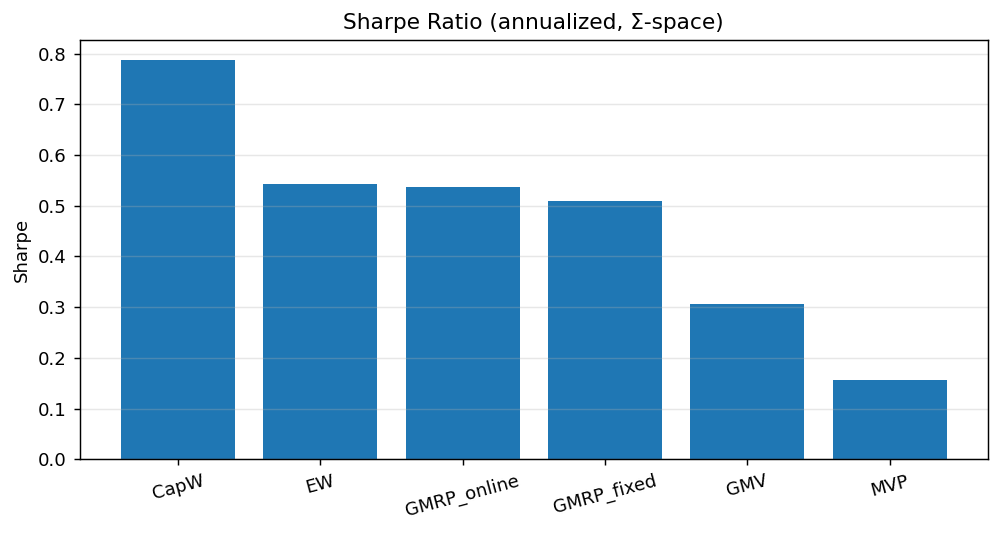

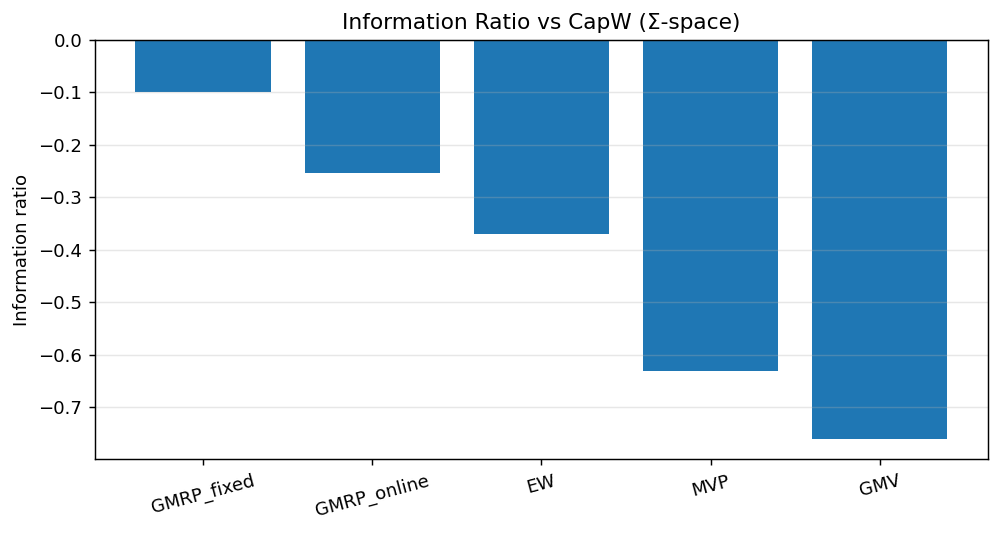

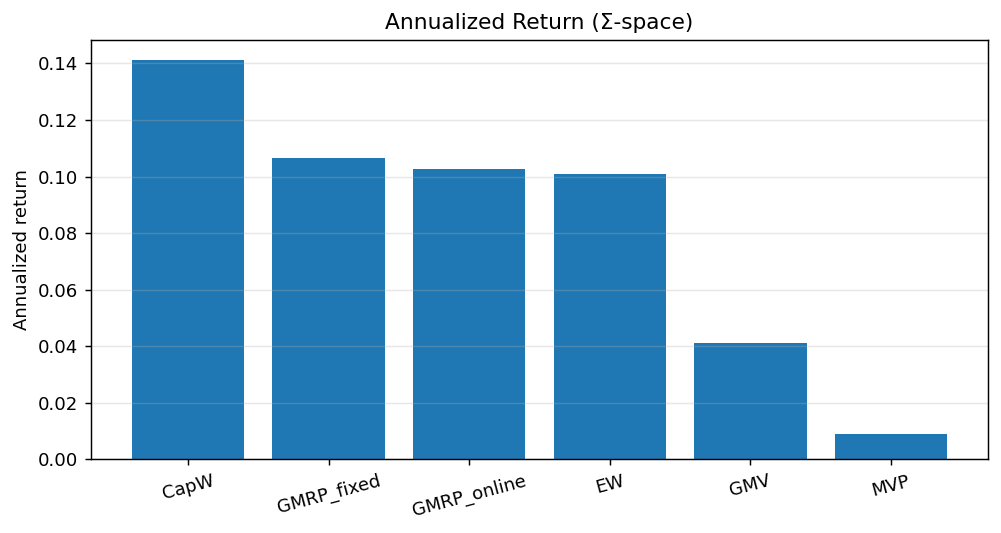

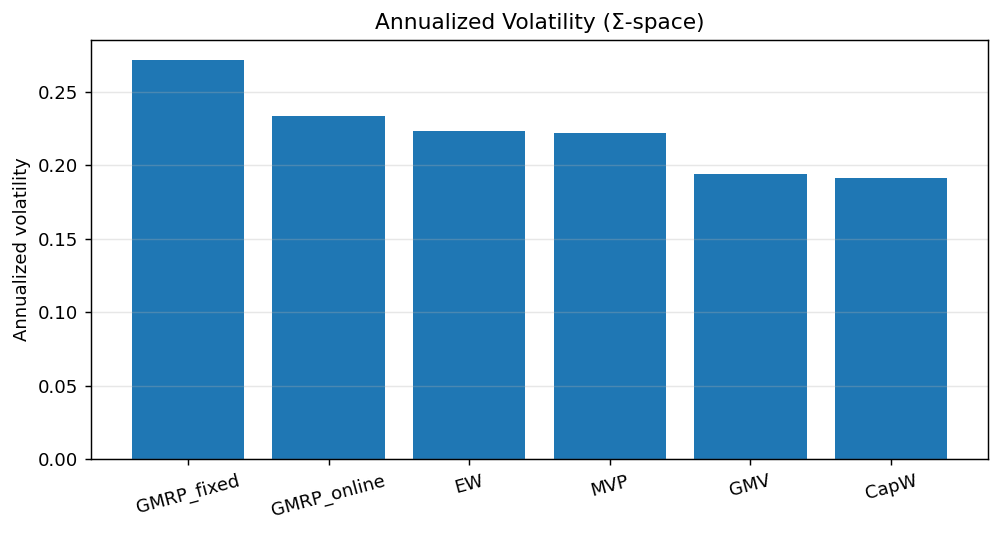

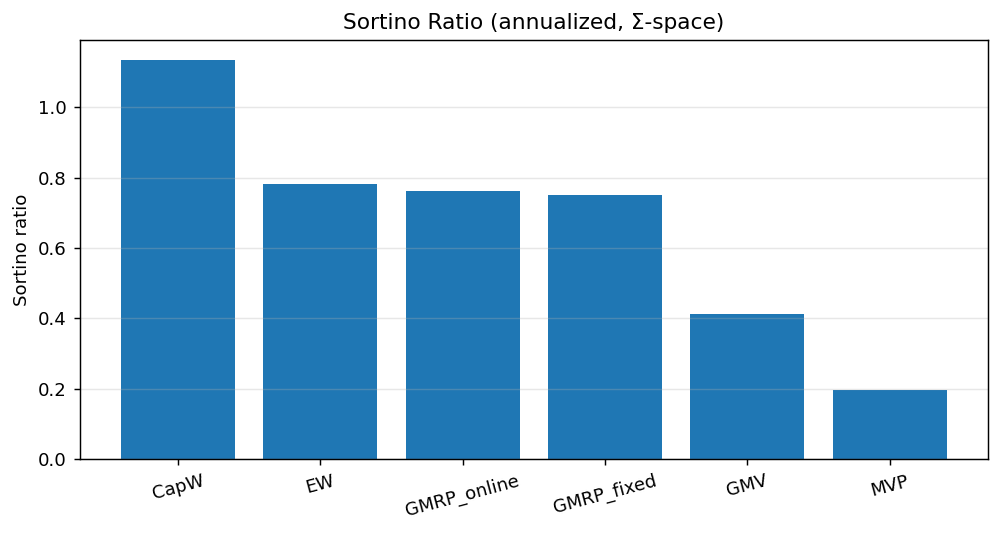

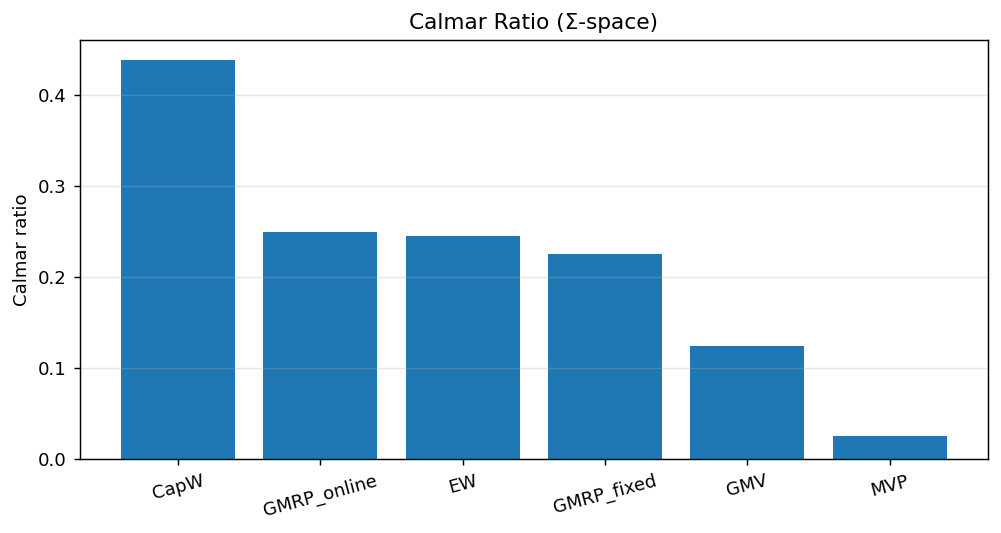

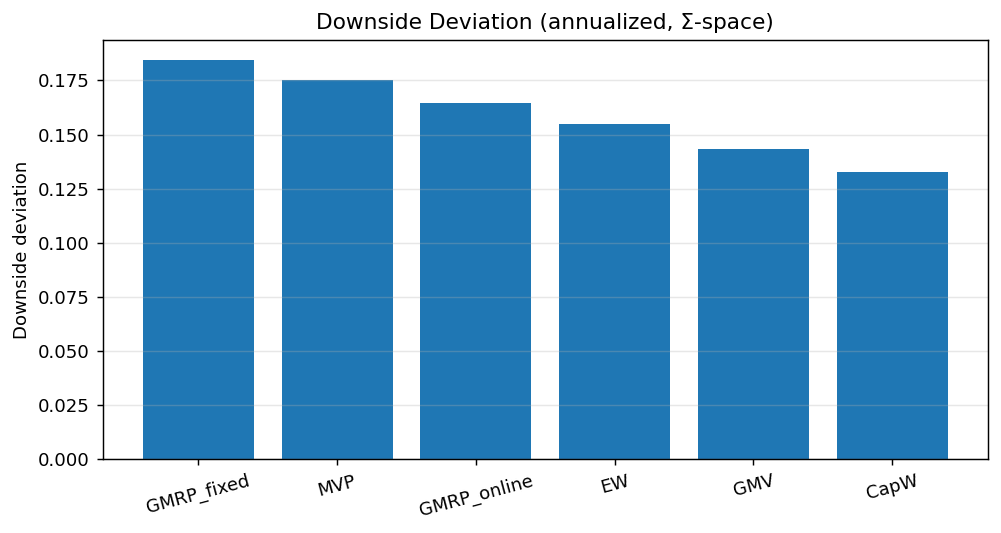

In [2]:
def plot_metric_bars(summary: pd.DataFrame,
                     metric: str,
                     title: str,
                     ylabel: str):
    if metric not in summary.columns:
        print(f"[skip] '{metric}' not in summary")
        return
    s = summary[metric].dropna().copy()
    if s.empty:
        print(f"[skip] '{metric}' has only NaNs")
        return

    s = s.sort_values(ascending=False)
    plt.figure(figsize=(7.8, 4.2))
    plt.bar(s.index, s.values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=15)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

metric_specs = [
    ("sharpe",     "Sharpe Ratio (annualized, Σ-space)",           "Sharpe"),
    ("info_ratio", f"Information Ratio vs {bench_name} (Σ-space)", "Information ratio"),
    ("ann_ret",    "Annualized Return (Σ-space)",                  "Annualized return"),
    ("ann_vol",    "Annualized Volatility (Σ-space)",              "Annualized volatility"),
    ("sortino",    "Sortino Ratio (annualized, Σ-space)",          "Sortino ratio"),
    ("calmar",     "Calmar Ratio (Σ-space)",                       "Calmar ratio"),
    ("dd_dev",     "Downside Deviation (annualized, Σ-space)",     "Downside deviation"),
]

for metric, title, ylabel in metric_specs:
    plot_metric_bars(summary, metric, title, ylabel)

In [3]:
# Block-bootstrap 95% CIs for Sharpe and IR (Σ-space)

def block_bootstrap_metric(
    r: pd.Series,
    fn_metric,
    block_len: int = 13,
    B: int = 1000,
    rng: np.random.Generator | None = None
):
    # Moving-block bootstrap: resample contiguous blocks to preserve local dependence.
    r0 = r.dropna()
    n = len(r0)
    if n == 0:
        return np.nan, (np.nan, np.nan)

    if rng is None:
        rng = np.random.default_rng(123)

    vals = r0.to_numpy()
    boot_vals = []

    for _ in range(B):
        idx = []
        while len(idx) < n:
            start = rng.integers(0, max(1, n - block_len + 1))
            idx.extend(range(start, min(n, start + block_len)))
        idx = idx[:n]
        rb = pd.Series(vals[idx])
        m = fn_metric(rb)
        if np.isfinite(m):
            boot_vals.append(m)

    if not boot_vals:
        return np.nan, (np.nan, np.nan)

    boot_arr = np.asarray(boot_vals, dtype=float)
    est = float(fn_metric(r0))
    lo, hi = np.percentile(boot_arr, [2.5, 97.5])
    return est, (float(lo), float(hi))

def ann_sharpe_weekly(r: pd.Series) -> float:
    # Wrapper so the bootstrap function can treat this as a single-argument metric.
    return float(ann_sharpe(r))

def info_ratio_weekly(r: pd.Series, bench: pd.Series) -> float:
    # IR is just a Sharpe ratio on the active return series.
    a, b = r.align(bench, join="inner")
    diff = a - b
    return float(ann_sharpe(diff))

bench = rets[bench_name].dropna()

rows_ci = []
for col in rets.columns:
    r = rets[col]

    # Sharpe CI for each strategy.
    sh_est, (sh_lo, sh_hi) = block_bootstrap_metric(
        r, ann_sharpe_weekly, block_len=13, B=1000
    )

    # IR CI vs benchmark (skip benchmark against itself).
    ir_est = ir_lo = ir_hi = np.nan
    if col != bench_name:
        ra, ba = r.align(bench, join="inner")
        diff = ra - ba
        ir_est, (ir_lo, ir_hi) = block_bootstrap_metric(
            diff, ann_sharpe_weekly, block_len=13, B=1000
        )

    rows_ci.append([col, sh_est, sh_lo, sh_hi, ir_est, ir_lo, ir_hi])

ci_df = (
    pd.DataFrame(
        rows_ci,
        columns=["strategy", "sharpe", "sh_lo", "sh_hi", "IR", "ir_lo", "ir_hi"],
    )
    .set_index("strategy")
    .sort_values("sharpe", ascending=False)
)

display(ci_df)

,sharpe,sh_lo,sh_hi,IR,ir_lo,ir_hi
strategy,,,,,,
CapW,0.787562,0.103039,1.684669,NaN,NaN,NaN
EW,0.543224,-0.185792,1.460349,-0.370706,-1.077544,0.428050
GMRP_online,0.537199,-0.203076,1.494351,-0.253754,-1.001649,0.369132
GMRP_fixed,0.509230,-0.257753,1.382854,-0.098713,-0.923976,0.678177
GMV,0.305714,-0.320601,1.048213,-0.761390,-1.388744,-0.152952
MVP,0.155785,-0.238536,0.751763,-0.630889,-1.277099,-0.080913


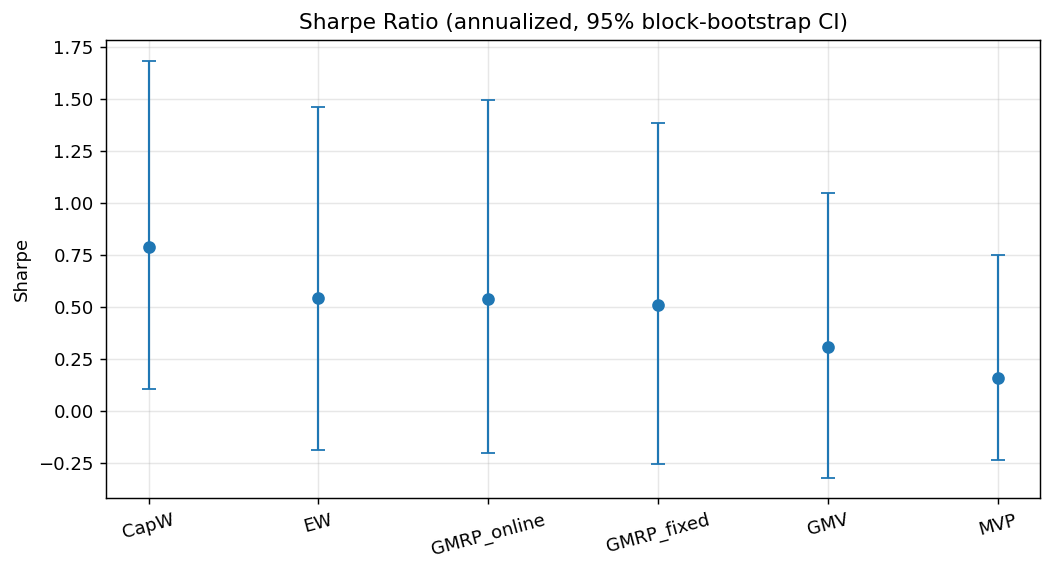

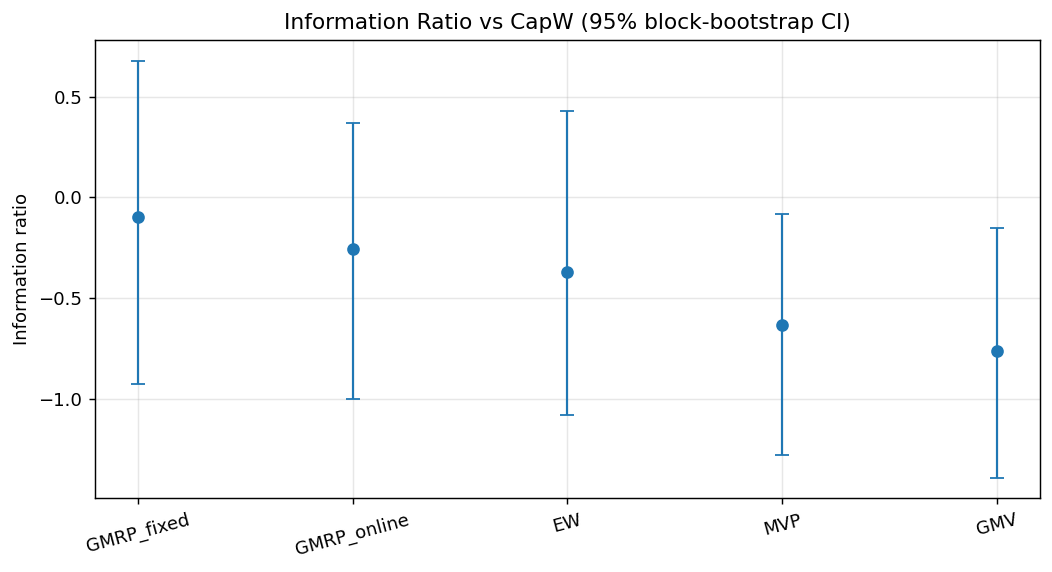

,n_weeks,ann_ret,ann_vol,sharpe,info_ratio,mdd,sortino,calmar,dd_dev
strategy,,,,,,,,,
CapW,335,0.141289,0.191487,0.787562,NaN,-0.322326,1.134212,0.438340,0.132963
EW,335,0.100930,0.223438,0.543224,-0.370706,-0.411845,0.782459,0.245067,0.155123
GMRP_online,335,0.102664,0.233501,0.537199,-0.253754,-0.411402,0.762042,0.249547,0.164606
GMRP_fixed,335,0.106581,0.271745,0.509230,-0.098713,-0.473611,0.749808,0.225039,0.184555
GMV,335,0.041044,0.193833,0.305714,-0.761390,-0.330334,0.413142,0.124251,0.143431
MVP,335,0.008868,0.221891,0.155785,-0.630889,-0.345335,0.197373,0.025679,0.175137


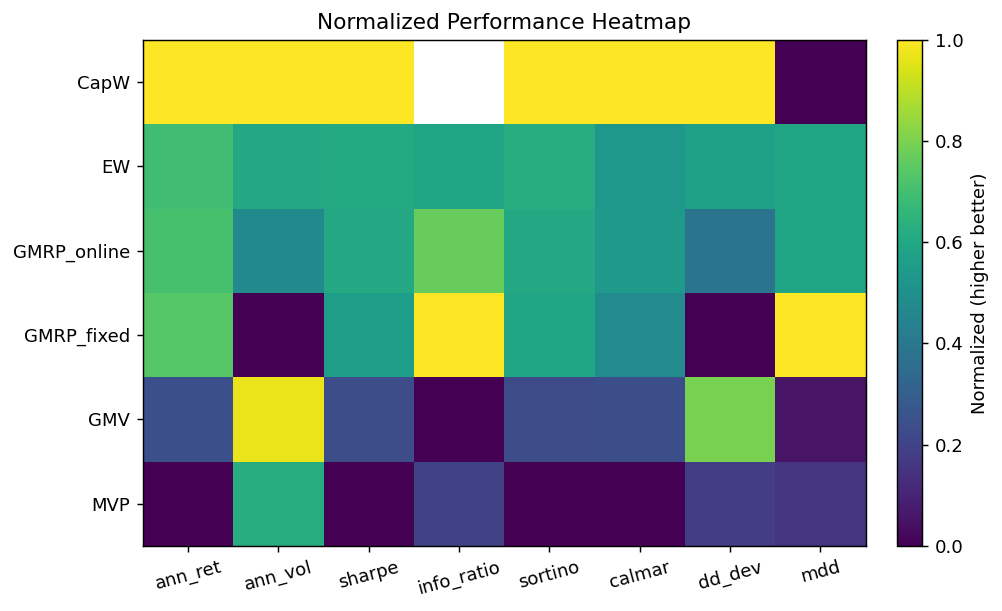

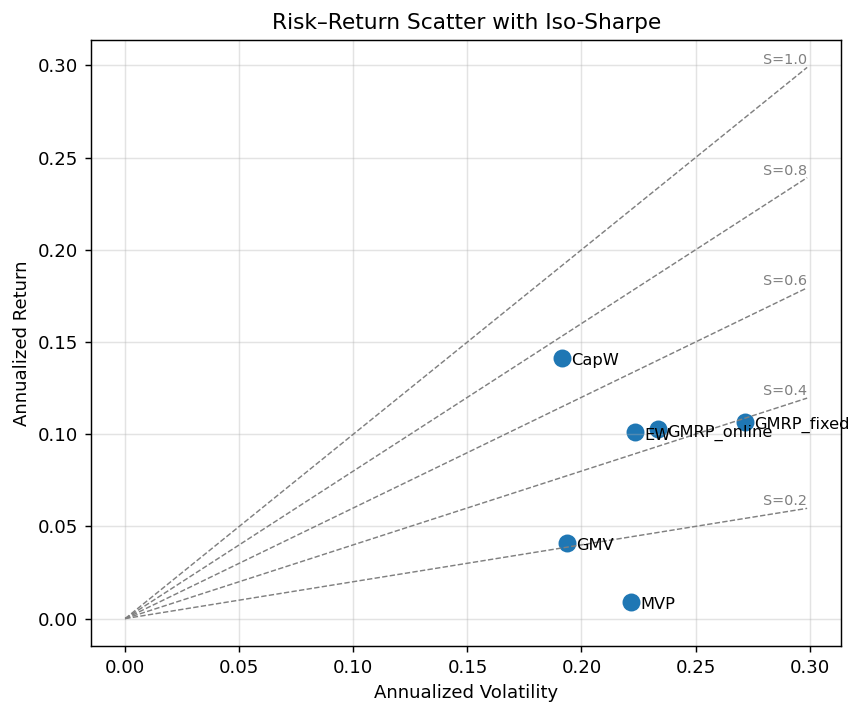

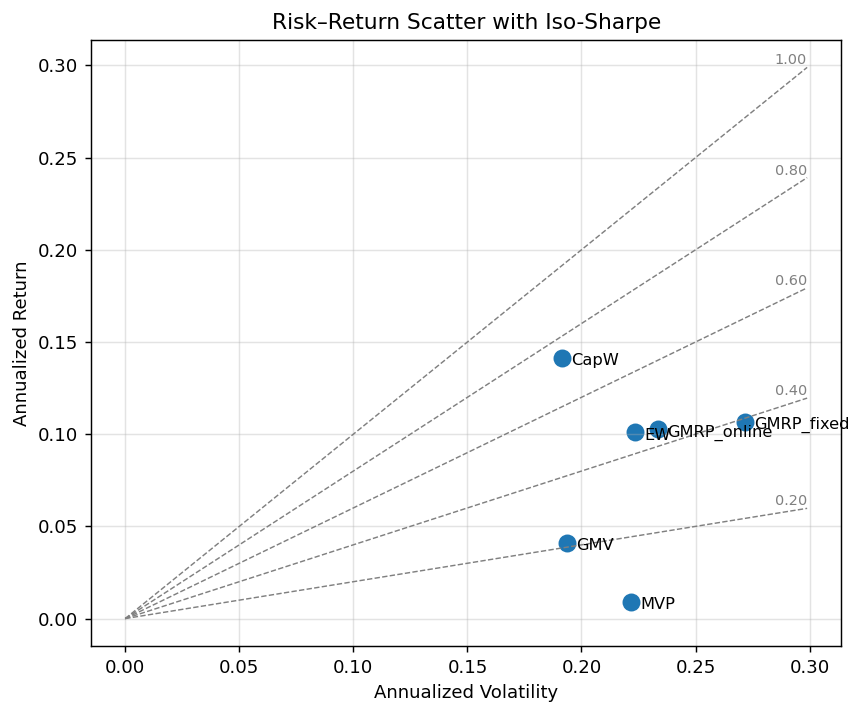

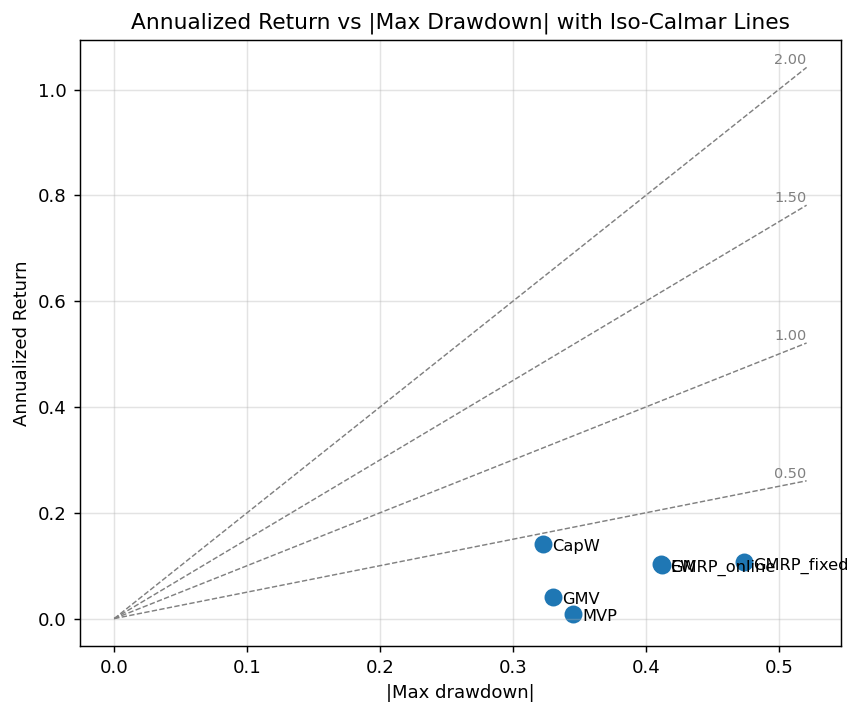

[info] Running iso-Sortino scatter...


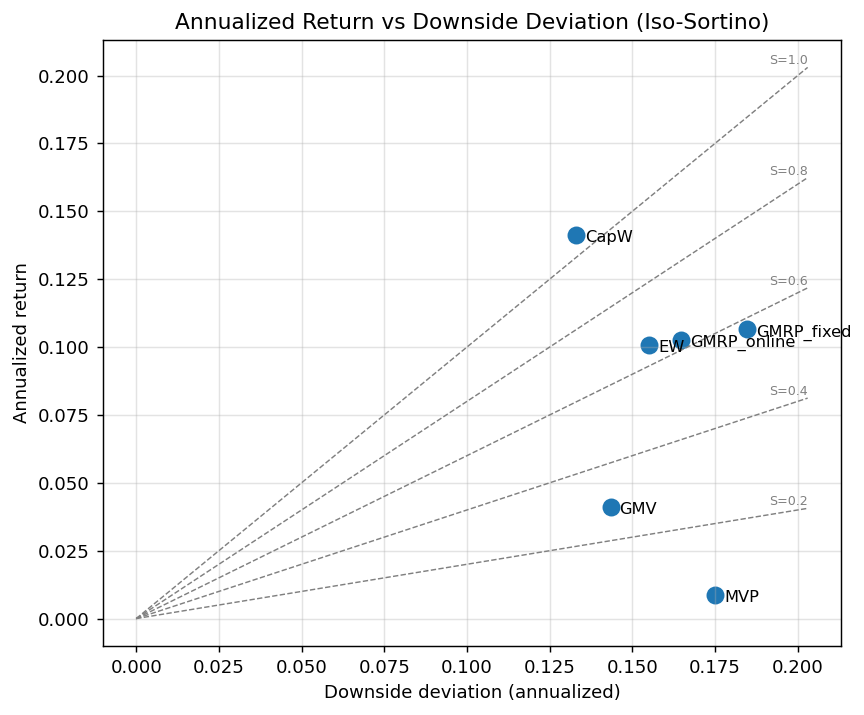

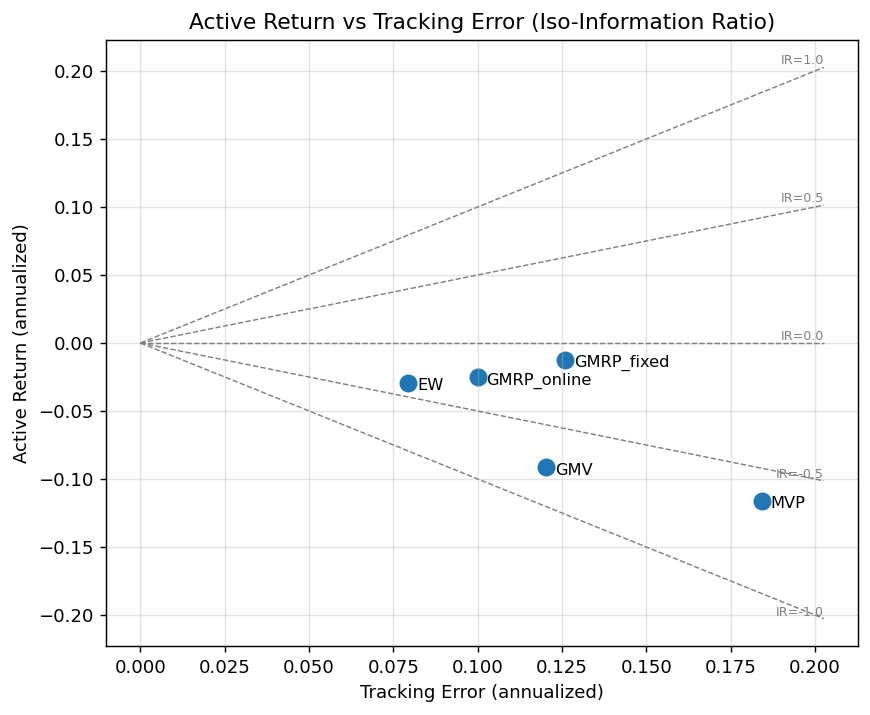

In [4]:
# Visualize Sharpe & IR with 95% CIs

def plot_with_ci(
    ci_df: pd.DataFrame,
    col_est: str,
    col_lo: str,
    col_hi: str,
    title: str,
    ylabel: str
):
    # Simple error-bar chart from the CI table.
    df = ci_df[[col_est, col_lo, col_hi]].dropna().sort_values(col_est, ascending=False)
    if df.empty:
        print(f"[skip] nothing to plot for {col_est}")
        return

    y = df[col_est].values
    yerr = np.vstack([
        y - df[col_lo].values,
        df[col_hi].values - y,
    ])

    plt.figure(figsize=(8.2, 4.5))
    plt.errorbar(df.index, y, yerr=yerr, fmt="o", capsize=4, lw=1.2)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=15)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_with_ci(
    ci_df,
    "sharpe", "sh_lo", "sh_hi",
    "Sharpe Ratio (annualized, 95% block-bootstrap CI)",
    "Sharpe",
)

plot_with_ci(
    ci_df,
    "IR", "ir_lo", "ir_hi",
    f"Information Ratio vs {bench_name} (95% block-bootstrap CI)",
    "Information ratio",
)

# Add a couple of drawdown-based metrics to the summary table.
summary["mdd"]    = rets.apply(max_drawdown, axis=0)
summary["calmar"] = rets.apply(calmar, axis=0)

display(summary)

# Normalize a basket of metrics into [0,1] for a quick “at-a-glance” heatmap.
metrics = [
    "ann_ret",
    "ann_vol",
    "sharpe",
    "info_ratio",
    "sortino",
    "calmar",
    "dd_dev",
    "mdd",
]
metrics = [m for m in metrics if m in summary.columns]
H = summary[metrics].copy()

# Flip risk-type metrics so higher always means better in the normalization.
invert = {"ann_vol": True, "dd_dev": True, "mdd": True}
for col, inv in invert.items():
    if inv and col in H.columns:
        H[col] = -H[col]

Hn = (H - H.min()) / (H.max() - H.min())

plt.figure(figsize=(7.8, 4.8))
im = plt.imshow(Hn.values, aspect="auto", cmap="viridis")

plt.xticks(range(Hn.shape[1]), Hn.columns, rotation=15)
plt.yticks(range(Hn.shape[0]), Hn.index)

plt.colorbar(im, fraction=0.046, pad=0.04, label="Normalized (higher better)")
plt.title("Normalized Performance Heatmap")
plt.tight_layout()
plt.show()

# Risk–return scatter with iso-Sharpe lines (annualized).
df_rr = summary[["ann_ret", "ann_vol"]].dropna().copy()
labels_rr = df_rr.index.tolist()

x = df_rr["ann_vol"].values
y = df_rr["ann_ret"].values

plt.figure(figsize=(6.8, 5.6))
plt.scatter(x, y, s=80)

for i, lbl in enumerate(labels_rr):
    plt.annotate(lbl, (x[i], y[i]), xytext=(5, -4),
                 textcoords="offset points", fontsize=9)

sharpe_levels = [0.2, 0.4, 0.6, 0.8, 1.0]
xx = np.linspace(0, max(1e-6, x.max() * 1.1), 200)

for s_ in sharpe_levels:
    yy = s_ * xx
    plt.plot(xx, yy, ls="--", lw=0.8, color="gray")
    plt.text(xx[-1], yy[-1], f"S={s_:.1f}",
             fontsize=8, va="bottom", ha="right", color="gray")

plt.title("Risk–Return Scatter with Iso-Sharpe")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.grid(alpha=0.35)
plt.tight_layout()
plt.show()

def iso_ratio_scatter(
    summary: pd.DataFrame,
    x_col: str,
    y_col: str,
    ratio_levels,
    title: str,
    xlabel: str,
    ylabel: str,
    exclude: list[str] | None = None,
    annotate: bool = True
):
    # Generic helper for ratio-style scatters where lines are y = kx.
    if x_col not in summary.columns or y_col not in summary.columns:
        print(f"[skip] {title} — '{x_col}' or '{y_col}' missing in summary.")
        return

    df = summary[[x_col, y_col]].dropna().copy()
    if exclude:
        df = df[~df.index.isin(exclude)]
    if df.empty:
        print(f"[skip] {title} — no data.")
        return

    labels = df.index.tolist()
    x = df[x_col].values
    y = df[y_col].values

    plt.figure(figsize=(6.8, 5.6))
    plt.scatter(x, y, s=80)

    if annotate:
        for i, lbl in enumerate(labels):
            plt.annotate(lbl, (x[i], y[i]), xytext=(5, -4),
                         textcoords="offset points", fontsize=9)

    x_max = max(1e-8, x.max() * 1.1)
    xx = np.linspace(0, x_max, 200)
    for k in ratio_levels:
        yy = k * xx
        plt.plot(xx, yy, ls="--", lw=0.8, color="gray")
        plt.text(xx[-1], yy[-1], f"{k:.2f}",
                 fontsize=8, va="bottom", ha="right", color="gray")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.35)
    plt.tight_layout()
    plt.show()

# Iso-Sharpe via the generic helper.
sh_levels = [0.2, 0.4, 0.6, 0.8, 1.0]
iso_ratio_scatter(
    summary=summary,
    x_col="ann_vol",
    y_col="ann_ret",
    ratio_levels=sh_levels,
    title="Risk–Return Scatter with Iso-Sharpe",
    xlabel="Annualized Volatility",
    ylabel="Annualized Return",
    exclude=None
)

# Iso-Calmar: annualized return vs |max drawdown|.
if "mdd" in summary.columns:
    summary["mdd_abs"] = summary["mdd"].abs()
    calmar_levels = [0.5, 1.0, 1.5, 2.0]
    iso_ratio_scatter(
        summary=summary,
        x_col="mdd_abs",
        y_col="ann_ret",
        ratio_levels=calmar_levels,
        title="Annualized Return vs |Max Drawdown| with Iso-Calmar Lines",
        xlabel="|Max drawdown|",
        ylabel="Annualized Return",
        exclude=None
    )
else:
    print("[info] mdd not in summary; skipping iso-Calmar plot.")

# Iso-Sortino: annualized return vs downside deviation.
if "sortino" in summary.columns and "dd_dev" in summary.columns:
    print("[info] Running iso-Sortino scatter...")
    df = summary[["ann_ret", "dd_dev"]].dropna().copy()
    labels = df.index.tolist()
    x = df["dd_dev"].values
    y = df["ann_ret"].values

    plt.figure(figsize=(6.8, 5.6))
    plt.scatter(x, y, s=80)
    for i, lbl in enumerate(labels):
        plt.annotate(lbl, (x[i], y[i]), xytext=(5, -4),
                     textcoords="offset points", fontsize=9)

    sortino_lvls = [0.2, 0.4, 0.6, 0.8, 1.0]
    xx = np.linspace(0, max(x) * 1.1, 400)
    for S in sortino_lvls:
        yy = S * xx
        plt.plot(xx, yy, ls="--", lw=0.8, color="gray")
        plt.text(xx[-1], yy[-1], f"S={S:.1f}",
                 fontsize=7, va="bottom", ha="right", color="gray")

    plt.title("Annualized Return vs Downside Deviation (Iso-Sortino)")
    plt.xlabel("Downside deviation (annualized)")
    plt.ylabel("Annualized return")
    plt.grid(alpha=0.35)
    plt.tight_layout()
    plt.show()
else:
    print("[info] Sortino/Downside deviation not available → skipping.")

# Tracking error vs CapW and iso-Information ratio.
rets_te = {}
cap = rets["CapW"].dropna()

for col in rets.columns:
    if col == "CapW":
        continue
    a, b = rets[col].align(cap, join="inner")
    diff = (a - b).dropna()
    if diff.empty:
        te = np.nan
    else:
        te = diff.std(ddof=1) * np.sqrt(WEEK_PER_YEAR)
    rets_te[col] = te

summary["tracking_error"] = pd.Series(rets_te)
summary["tracking_error"].fillna(np.nan, inplace=True)

if "tracking_error" in summary.columns:
    act_ret = {}
    for col in rets.columns:
        if col == "CapW":
            continue
        a, b = rets[col].align(rets["CapW"], join="inner")
        diff = (a - b).dropna()
        act_ret[col] = diff.mean() * WEEK_PER_YEAR
    summary["act_ret"] = pd.Series(act_ret)

    df_ir = summary[["act_ret", "tracking_error"]].dropna().copy()
    if not df_ir.empty:
        labels = df_ir.index.tolist()
        x = df_ir["tracking_error"].values
        y = df_ir["act_ret"].values

        plt.figure(figsize=(6.8, 5.6))
        plt.scatter(x, y, s=80)
        for i, lbl in enumerate(labels):
            plt.annotate(lbl, (x[i], y[i]), xytext=(5, -4),
                         textcoords="offset points", fontsize=9)

        IR_levels = [-1.0, -0.5, 0.0, 0.5, 1.0]
        xx = np.linspace(0, max(x) * 1.1, 400)
        for IR in IR_levels:
            yy = IR * xx
            plt.plot(xx, yy, ls="--", lw=0.8, color="gray")
            plt.text(xx[-1], yy[-1], f"IR={IR:.1f}",
                     fontsize=7, va="bottom", ha="right", color="gray")

        plt.title("Active Return vs Tracking Error (Iso-Information Ratio)")
        plt.xlabel("Tracking Error (annualized)")
        plt.ylabel("Active Return (annualized)")
        plt.grid(alpha=0.35)
        plt.tight_layout()
        plt.show()
else:
    print("[info] Tracking error missing → skipping iso-IR plot.")